Connected to mechinterp (Python 3.10.15)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Model + SAE', 'Zero-Ablated Circuit']
ablated_values = [model_sae_activation_ablated, L40_9682_activation_circuit_ablated]
non_ablated_values = [model_sae_activation, L40_9682_activation_circuit]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width / 2, ablated_values, width=bar_width, label='Duplicate Latents Ablated (only 2)', color='#4C72B0')
bars2 = plt.bar(x + bar_width / 2, non_ablated_values, width=bar_width, label='Duplicate Latents Not Ablated', color='#55A868')

# Title and labels
plt.title("Effect of ablating duplicate token latents on \n Mean Activation for L40_9682 for error free code \n (Last 3 Tokens)", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Mean Activation Value", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

NameError: name 'model_sae_activation_ablated' is not defined

In [2]:
import os
import gc
import torch
os.chdir("/work/pi_jensen_umass_edu/jnainani_umass_edu/CircuitAnalysisSAEs")
import json
from sae_lens import SAE, HookedSAETransformer
from circ4latents import data_gen
from functools import partial
import einops

# Function to manage CUDA memory and clean up
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()
# cleanup_cuda()
# Load the config
with open("config.json", 'r') as file:
   config = json.load(file)
token = config.get('huggingface_token', None)
os.environ["HF_TOKEN"] = token

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

hf_cache = "/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/huggingface_cache/hub"
os.environ["HF_HOME"] = hf_cache

# Load the model
model = HookedSAETransformer.from_pretrained("google/gemma-2-9b", device=device, cache_dir=hf_cache)

layers= [7, 14, 21, 40]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res-canonical", sae_id=f"layer_{layer}/width_16k/canonical", device=device)[0] for layer in layers]

/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


Loading checkpoint shards: 100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [3]:
# Updated version to return JSON with more names and structure for correct and incorrect keying examples

import json
import random

# Expanding the name pool with a larger set of names
extended_name_pool = [
    "Bob", "Sam", "Lilly", "Rob", "Alice", "Charlie", "Sally", "Tom", "Jake", "Emily", 
    "Megan", "Chris", "Sophia", "James", "Oliver", "Isabella", "Mia", "Jackson", 
    "Emma", "Ava", "Lucas", "Benjamin", "Ethan", "Grace", "Olivia", "Liam", "Noah"
]

for name in extended_name_pool:
    assert len(model.tokenizer.encode(name)) == 2, f"Name {name} has more than 1 token"

# Function to generate the dataset with correct and incorrect keying into dictionaries
def generate_extended_dataset(name_pool, num_samples=5):
    dataset = []
    
    for _ in range(num_samples):
        # Randomly select 5 names from the pool
        selected_names = random.sample(name_pool, 5)
        # Assign random ages to the selected names
        age_dict = {name: random.randint(10, 19) for name in selected_names}
        
        # Create a correct example
        correct_name = random.choice(list(age_dict.keys()))
        correct_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{correct_name}"]\n'
        correct_response = age_dict[correct_name]
        correct_token = str(correct_response)[0]
        
        # Create an incorrect example with a name not in the dictionary
        incorrect_name = random.choice([name for name in name_pool if name not in age_dict])
        incorrect_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{incorrect_name}"]\n'
        incorrect_response = "Traceback"
        incorrect_token = "Traceback"
        
        # Append the pair of correct and incorrect examples
        dataset.append({
            "correct": {
                "prompt": correct_prompt,
                "response": correct_response,
                "token": correct_token
            },
            "error": {
                "prompt": incorrect_prompt,
                "response": incorrect_response,
                "token": incorrect_token
            }
        })
        
    return dataset

# Generate the extended dataset
json_dataset = generate_extended_dataset(extended_name_pool, num_samples=100_000)

clean_prompts = []
corr_prompts = []

answer_token = model.to_single_token("1")
traceback_token = model.to_single_token("Traceback")

for item in json_dataset[:50]:
    corr_prompts.append(item["correct"]["prompt"])
    clean_prompts.append(item["error"]["prompt"])

clean_tokens = model.to_tokens(clean_prompts)
corr_tokens = model.to_tokens(corr_prompts)

In [4]:
def logit_diff_fn(logits):
    err = logits[:, -1, traceback_token]
    no_err = logits[:, -1, answer_token]
    return (err - no_err).mean()

# Disable gradients for all parameters
for param in model.parameters():
   param.requires_grad_(False)

# # Compute logits for clean and corrupted samples
logits = model(clean_tokens)
clean_diff = logit_diff_fn(logits)

logits = model(corr_tokens)
corr_diff = logit_diff_fn(logits)

print(f"clean_diff: {clean_diff}")
print(f"corr_diff: {corr_diff}")

# # Cleanup
del logits
cleanup_cuda()

# # Define error type metric
def _err_type_metric(logits, clean_logit_diff, corr_logit_diff):
    patched_logit_diff = logit_diff_fn(logits)
    return (patched_logit_diff - corr_logit_diff) / (clean_logit_diff - corr_logit_diff)

err_metric_denoising = partial(_err_type_metric, clean_logit_diff=clean_diff, corr_logit_diff=corr_diff)

clean_diff: 7.13979959487915
corr_diff: -6.852413654327393


In [5]:
def run_with_saes_filtered_cache(tokens, filtered_ids, model, saes):
    with torch.no_grad():  # Global no_grad for performance
        
        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Equivalent to unsqueeze(-1)

        sae_outs = {}
        
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Apply torch.where only if mask_expanded has True values
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_outs


def run_with_saes_latent_op_patch(new_tokens, filtered_ids, model, saes, cache, dict_feats):
   # Ensure tokens are a torch.Tensor
   if not isinstance(new_tokens, torch.Tensor):
       new_tokens = torch.tensor(new_tokens).to(model.cfg.device)  # Move to the device of the model

   # Create a mask where True indicates positions to modify
   mask = torch.ones_like(new_tokens, dtype=torch.bool)
   for token_id in filtered_ids:
       mask &= new_tokens != token_id

   # Expand the mask once, so it matches the shape [batch_size, seq_len, 1]
   mask_expanded = mask.unsqueeze(-1)  # Expand to allow broadcasting
   mask_expanded = mask_expanded.to(model.cfg.device)  # Move the mask to the same device as the model
   # For each SAE, add the appropriate hook
   for sae in saes:
       hook_point = sae.cfg.hook_name

       # Define the filtered hook function (optimized)
       def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
           # Apply the SAE only where mask_expanded is True
           enc_sae = sae.encode(act)  # Call the SAE once
          
           if hook.name in cache and hook.name in dict_feats:
               prev_sae = cache[hook.name].to(device)   # Get cached activations from the cache
               feature_indices = dict_feats[hook.name]  # Get the feature indices to patch

               for feature_idx in range(sae.cfg.d_sae):
                   if feature_idx in feature_indices:
                       enc_sae[:, :, feature_idx] = prev_sae[:, :, feature_idx]

           # After patching, decode the modified enc_sae
           modified_act = sae.decode(enc_sae)

           # In-place update where the mask is True
           updated_act = torch.where(mask_expanded, modified_act, act)

           return updated_act

       # Add the hook to the model
       model.add_hook(hook_point, filtered_hook, dir='fwd')

   # Run the model with the tokens (no gradients needed)
   with torch.no_grad():
       logits = model(new_tokens)

   # Reset the hooks after computation to free memory
   model.reset_hooks()

   return logits  # Return only the logits

def run_with_saes_latent_op_patch_cache(new_tokens, filtered_ids, model, saes, cache, dict_feats):
    with torch.no_grad():  # Global no_grad for efficiency

        # Ensure new_tokens is a tensor on the correct device
        new_tokens = torch.as_tensor(new_tokens, device=model.cfg.device)
        
        # Create mask in a vectorized way
        mask = ~torch.isin(new_tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Expand dimensions directly
        
        # Cache hook names and feature indices outside the hook
        sae_hook_configs = [(sae.cfg.hook_name, sae, dict_feats.get(sae.cfg.hook_name, [])) for sae in saes]
        sae_outs = {}

        # Define and apply hooks
        for hook_name, sae, feature_indices in sae_hook_configs:
            def filtered_hook(act, hook, sae=sae, feature_indices=feature_indices, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                if hook.name in cache and feature_indices:
                    # Vectorized update of selected feature indices
                    enc_sae[:, :, feature_indices] = cache[hook.name][:, :, feature_indices].to(device) 

                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Only apply torch.where if needed
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_name, filtered_hook, dir='fwd')

        logits = model(new_tokens)
        model.reset_hooks()

    return logits, sae_outs
    
def run_with_saes_zero_ablation(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]

        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0

                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits


def run_with_saes_zero_ablation_cache(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out


def run_with_saes_zero_ablation_cache_tokens(tokens, filtered_ids, model, saes, dict_feats, token_pos):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    # Zero out only at specified token positions
                    for pos in token_pos:
                        enc_sae[:, pos, zero_indices] = 0
                    # enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out

In [6]:
cleanup_cuda()

In [7]:
model.reset_hooks()
filtered_ids = [model.tokenizer.bos_token_id]
clean_sae_logits, clean_sae_cache = run_with_saes_filtered_cache(clean_tokens, filtered_ids, model, saes)
corr_sae_logits, corr_sae_cache = run_with_saes_filtered_cache(corr_tokens, filtered_ids, model, saes)

clean_sae_diff = logit_diff_fn(clean_sae_logits)
corr_sae_diff = logit_diff_fn(corr_sae_logits)

print(f"clean_sae_diff: {clean_sae_diff}")
print(f"corr_sae_diff: {corr_sae_diff}")

clean_sae_diff: 2.0518038272857666
corr_sae_diff: -6.695716857910156


In [8]:
with open('mask_finding/mask.json') as f:
    mask = json.load(f)

# load clustered latnets as cluster_results 
with open('mask_finding/out/clustering/clustered_latents.json') as f:
    cluster_results = json.load(f)

# load the drop results json
with open('mask_finding/out/clustering/drop_results.json') as f:
    drop_results = json.load(f)

In [9]:
model.reset_hooks()
logits = run_with_saes_zero_ablation(clean_tokens, filtered_ids, model, saes, mask)
clean_sae_diff_ablation = logit_diff_fn(logits)
print(f"clean_sae_diff_ablation: {clean_sae_diff_ablation}")

logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
corr_sae_diff_ablation = logit_diff_fn(logits)
print(f"corr_sae_diff_ablation: {corr_sae_diff_ablation}")

clean_sae_diff_ablation: 0.6442261338233948
corr_sae_diff_ablation: -1.593661904335022


In [10]:
del logits 
cleanup_cuda()

In [11]:
model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens(corr_tokens, filtered_ids, model, saes, {}, [])
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
model_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_full)

fully_filtered_mask = {'blocks.7.hook_resid_post': list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))}
model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens(corr_tokens, filtered_ids, model, saes, fully_filtered_mask, [-3])
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
model_dup_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_dup_ablated)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  0.001320487237535417


NameError: name 'duplicate_latents' is not defined

In [12]:
# Step 1: Define duplicate latents and create filtered mask
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens(corr_tokens, filtered_ids, model, saes, {}, [])
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
model_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_full)

fully_filtered_mask = {'blocks.7.hook_resid_post': list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))}
model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens(corr_tokens, filtered_ids, model, saes, fully_filtered_mask, [-3])
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
model_dup_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_dup_ablated)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  0.001320487237535417
Duplicate cluster ablated, all latents:  0.04117686673998833


In [13]:
# Step 1: Define duplicate latents and create filtered mask
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens(corr_tokens, filtered_ids, model, saes, {}, [])
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
model_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_full)

fully_filtered_mask = {'blocks.7.hook_resid_post': list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))}
model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens(corr_tokens, filtered_ids, model, saes, fully_filtered_mask, [-3, -2, -1])
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
model_dup_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_dup_ablated)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  0.001320487237535417
Duplicate cluster ablated, all latents:  0.04117686673998833


In [14]:
def run_with_saes_filtered_cache(tokens, filtered_ids, model, saes):
    with torch.no_grad():  # Global no_grad for performance
        
        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Equivalent to unsqueeze(-1)

        sae_outs = {}
        
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Apply torch.where only if mask_expanded has True values
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_outs


def run_with_saes_latent_op_patch(new_tokens, filtered_ids, model, saes, cache, dict_feats):
   # Ensure tokens are a torch.Tensor
   if not isinstance(new_tokens, torch.Tensor):
       new_tokens = torch.tensor(new_tokens).to(model.cfg.device)  # Move to the device of the model

   # Create a mask where True indicates positions to modify
   mask = torch.ones_like(new_tokens, dtype=torch.bool)
   for token_id in filtered_ids:
       mask &= new_tokens != token_id

   # Expand the mask once, so it matches the shape [batch_size, seq_len, 1]
   mask_expanded = mask.unsqueeze(-1)  # Expand to allow broadcasting
   mask_expanded = mask_expanded.to(model.cfg.device)  # Move the mask to the same device as the model
   # For each SAE, add the appropriate hook
   for sae in saes:
       hook_point = sae.cfg.hook_name

       # Define the filtered hook function (optimized)
       def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
           # Apply the SAE only where mask_expanded is True
           enc_sae = sae.encode(act)  # Call the SAE once
          
           if hook.name in cache and hook.name in dict_feats:
               prev_sae = cache[hook.name].to(device)   # Get cached activations from the cache
               feature_indices = dict_feats[hook.name]  # Get the feature indices to patch

               for feature_idx in range(sae.cfg.d_sae):
                   if feature_idx in feature_indices:
                       enc_sae[:, :, feature_idx] = prev_sae[:, :, feature_idx]

           # After patching, decode the modified enc_sae
           modified_act = sae.decode(enc_sae)

           # In-place update where the mask is True
           updated_act = torch.where(mask_expanded, modified_act, act)

           return updated_act

       # Add the hook to the model
       model.add_hook(hook_point, filtered_hook, dir='fwd')

   # Run the model with the tokens (no gradients needed)
   with torch.no_grad():
       logits = model(new_tokens)

   # Reset the hooks after computation to free memory
   model.reset_hooks()

   return logits  # Return only the logits

def run_with_saes_latent_op_patch_cache(new_tokens, filtered_ids, model, saes, cache, dict_feats):
    with torch.no_grad():  # Global no_grad for efficiency

        # Ensure new_tokens is a tensor on the correct device
        new_tokens = torch.as_tensor(new_tokens, device=model.cfg.device)
        
        # Create mask in a vectorized way
        mask = ~torch.isin(new_tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Expand dimensions directly
        
        # Cache hook names and feature indices outside the hook
        sae_hook_configs = [(sae.cfg.hook_name, sae, dict_feats.get(sae.cfg.hook_name, [])) for sae in saes]
        sae_outs = {}

        # Define and apply hooks
        for hook_name, sae, feature_indices in sae_hook_configs:
            def filtered_hook(act, hook, sae=sae, feature_indices=feature_indices, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                if hook.name in cache and feature_indices:
                    # Vectorized update of selected feature indices
                    enc_sae[:, :, feature_indices] = cache[hook.name][:, :, feature_indices].to(device) 

                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Only apply torch.where if needed
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_name, filtered_hook, dir='fwd')

        logits = model(new_tokens)
        model.reset_hooks()

    return logits, sae_outs
    
def run_with_saes_zero_ablation(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]

        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0

                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits


def run_with_saes_zero_ablation_cache(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out


def run_with_saes_zero_ablation_cache_tokens(tokens, filtered_ids, model, saes, dict_feats, token_pos):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    # Zero out only at specified token positions
                    for pos in token_pos:
                        enc_sae[:, pos, zero_indices] = 0
                    # enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out


def run_with_saes_zero_ablation_cache_tokens_separate(tokens, filtered_ids, model, saes, dict_feats, dict_feats_v2, token_pos):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    feature_indices_v2 = dict_feats_v2[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)

                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]

                    zero_indices_v2 = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices_v2, device=model.cfg.device))]
                    # Zero out only at specified token positions
                    for pos in token_pos:
                        enc_sae[:, pos, zero_indices_v2] = 0
                    enc_sae[:, :, zero_indices] = 0
                    # enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out

In [15]:
# Step 1: Define duplicate latents and create filtered mask
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

# filtered_mask = mask.copy()
# filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set( duplicate_latents))
token_pos = [-3, -2, -1]

empty_mask = {}
for key in mask.keys():
    empty_mask[key] = []


model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens_separate(corr_tokens, filtered_ids, model, saes, mask, empty_mask, token_pos)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
circuit_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",circuit_full)

fully_filtered_mask = {'blocks.7.hook_resid_post': list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))}
model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens_separate(corr_tokens, filtered_ids, model, saes, mask, fully_filtered_mask, token_pos)
log_probs = log_probs[:, -1, traceback_token]
circuit_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ", circuit_ablated)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  1.3014511343611979e-11


KeyError: 'blocks.14.hook_resid_post'

In [16]:
# Step 1: Define duplicate latents and create filtered mask
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

# filtered_mask = mask.copy()
# filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set( duplicate_latents))
token_pos = [-3, -2, -1]

empty_mask = {}
for key in mask.keys():
    empty_mask[key] = []

model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens_separate(corr_tokens, filtered_ids, model, saes, mask, empty_mask, token_pos)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
circuit_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",circuit_full)

fully_filtered_mask = {}
for key in mask.keys():
    fully_filtered_mask[key] = []
fully_filtered_mask = {'blocks.7.hook_resid_post': list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))}
model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens_separate(corr_tokens, filtered_ids, model, saes, mask, fully_filtered_mask, token_pos)
log_probs = log_probs[:, -1, traceback_token]
circuit_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ", circuit_ablated)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  1.3014511343611979e-11


KeyError: 'blocks.14.hook_resid_post'

In [17]:
# Step 1: Define duplicate latents and create filtered mask
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

# filtered_mask = mask.copy()
# filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set( duplicate_latents))
token_pos = [-3, -2, -1]

empty_mask = {}
for key in mask.keys():
    empty_mask[key] = []

model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens_separate(corr_tokens, filtered_ids, model, saes, mask, empty_mask, token_pos)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
circuit_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",circuit_full)

fully_filtered_mask = {}
for key in mask.keys():
    fully_filtered_mask[key] = []
fully_filtered_mask = {'blocks.7.hook_resid_post': list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))}
model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens_separate(corr_tokens, filtered_ids, model, saes, mask, fully_filtered_mask, token_pos)
log_probs = log_probs[:, -1, traceback_token]
circuit_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ", circuit_ablated)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  1.3014511343611979e-11


KeyError: 'blocks.14.hook_resid_post'

In [18]:
fully_filtered_mask

## %%
# Step 1: Define duplicate latents and create filtered mask
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens(corr_tokens, filtered_ids, model, saes, {}, [])
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
model_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_full)

fully_filtered_mask = {'blocks.7.hook_resid_post': list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))}
model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens(corr_tokens, filtered_ids, model, saes, fully_filtered_mask, [-3, -2, -1])
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
model_dup_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_dup_ablated)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  0.001320487237535417
Duplicate cluster ablated, all latents:  0.04117686673998833


In [19]:
fully_filtered_mask

{'blocks.7.hook_resid_post': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  15

In [20]:
# Step 1: Define duplicate latents and create filtered mask
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

# filtered_mask = mask.copy()
# filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set( duplicate_latents))
token_pos = [-3, -2, -1]

empty_mask = {}
for key in mask.keys():
    empty_mask[key] = []

model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens_separate(corr_tokens, filtered_ids, model, saes, mask, empty_mask, token_pos)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
circuit_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",circuit_full)

fully_filtered_mask = {}
for key in mask.keys():
    fully_filtered_mask[key] = []
fully_filtered_mask['blocks.7.hook_resid_post'] = list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))
model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens_separate(corr_tokens, filtered_ids, model, saes, mask, fully_filtered_mask, token_pos)
log_probs = log_probs[:, -1, traceback_token]
circuit_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ", circuit_ablated)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  1.3014511343611979e-11


IndexError: too many indices for tensor of dimension 1

In [21]:
# Step 1: Define duplicate latents and create filtered mask
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

# filtered_mask = mask.copy()
# filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set( duplicate_latents))
token_pos = [-3, -2, -1]

empty_mask = {}
for key in mask.keys():
    empty_mask[key] = []

model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens_separate(corr_tokens, filtered_ids, model, saes, mask, empty_mask, token_pos)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
circuit_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",circuit_full)

fully_filtered_mask = {}
for key in mask.keys():
    fully_filtered_mask[key] = []
fully_filtered_mask['blocks.7.hook_resid_post'] = list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))
model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens_separate(corr_tokens, filtered_ids, model, saes, mask, fully_filtered_mask, token_pos)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
circuit_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ", circuit_ablated)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  1.3014511343611979e-11
Duplicate cluster ablated, all latents:  1.3014511343611979e-11


In [22]:
def run_with_saes_filtered_cache(tokens, filtered_ids, model, saes):
    with torch.no_grad():  # Global no_grad for performance
        
        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Equivalent to unsqueeze(-1)

        sae_outs = {}
        
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Apply torch.where only if mask_expanded has True values
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_outs


def run_with_saes_latent_op_patch(new_tokens, filtered_ids, model, saes, cache, dict_feats):
   # Ensure tokens are a torch.Tensor
   if not isinstance(new_tokens, torch.Tensor):
       new_tokens = torch.tensor(new_tokens).to(model.cfg.device)  # Move to the device of the model

   # Create a mask where True indicates positions to modify
   mask = torch.ones_like(new_tokens, dtype=torch.bool)
   for token_id in filtered_ids:
       mask &= new_tokens != token_id

   # Expand the mask once, so it matches the shape [batch_size, seq_len, 1]
   mask_expanded = mask.unsqueeze(-1)  # Expand to allow broadcasting
   mask_expanded = mask_expanded.to(model.cfg.device)  # Move the mask to the same device as the model
   # For each SAE, add the appropriate hook
   for sae in saes:
       hook_point = sae.cfg.hook_name

       # Define the filtered hook function (optimized)
       def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
           # Apply the SAE only where mask_expanded is True
           enc_sae = sae.encode(act)  # Call the SAE once
          
           if hook.name in cache and hook.name in dict_feats:
               prev_sae = cache[hook.name].to(device)   # Get cached activations from the cache
               feature_indices = dict_feats[hook.name]  # Get the feature indices to patch

               for feature_idx in range(sae.cfg.d_sae):
                   if feature_idx in feature_indices:
                       enc_sae[:, :, feature_idx] = prev_sae[:, :, feature_idx]

           # After patching, decode the modified enc_sae
           modified_act = sae.decode(enc_sae)

           # In-place update where the mask is True
           updated_act = torch.where(mask_expanded, modified_act, act)

           return updated_act

       # Add the hook to the model
       model.add_hook(hook_point, filtered_hook, dir='fwd')

   # Run the model with the tokens (no gradients needed)
   with torch.no_grad():
       logits = model(new_tokens)

   # Reset the hooks after computation to free memory
   model.reset_hooks()

   return logits  # Return only the logits

def run_with_saes_latent_op_patch_cache(new_tokens, filtered_ids, model, saes, cache, dict_feats):
    with torch.no_grad():  # Global no_grad for efficiency

        # Ensure new_tokens is a tensor on the correct device
        new_tokens = torch.as_tensor(new_tokens, device=model.cfg.device)
        
        # Create mask in a vectorized way
        mask = ~torch.isin(new_tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Expand dimensions directly
        
        # Cache hook names and feature indices outside the hook
        sae_hook_configs = [(sae.cfg.hook_name, sae, dict_feats.get(sae.cfg.hook_name, [])) for sae in saes]
        sae_outs = {}

        # Define and apply hooks
        for hook_name, sae, feature_indices in sae_hook_configs:
            def filtered_hook(act, hook, sae=sae, feature_indices=feature_indices, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                if hook.name in cache and feature_indices:
                    # Vectorized update of selected feature indices
                    enc_sae[:, :, feature_indices] = cache[hook.name][:, :, feature_indices].to(device) 

                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Only apply torch.where if needed
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_name, filtered_hook, dir='fwd')

        logits = model(new_tokens)
        model.reset_hooks()

    return logits, sae_outs
    
def run_with_saes_zero_ablation(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]

        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0

                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits


def run_with_saes_zero_ablation_cache(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out


def run_with_saes_zero_ablation_cache_tokens(tokens, filtered_ids, model, saes, dict_feats, token_pos):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    # Zero out only at specified token positions
                    for pos in token_pos:
                        enc_sae[:, pos, zero_indices] = 0
                    # enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out


def run_with_saes_zero_ablation_cache_tokens_separate(tokens, filtered_ids, model, saes, dict_feats, dict_feats_v2, token_pos):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    feature_indices_v2 = dict_feats_v2[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)

                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]

                    enc_sae[:, :, zero_indices] = 0

                    zero_indices_v2 = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices_v2, device=model.cfg.device))]
                    # Zero out only at specified token positions
                    if feature_indices_v2:
                        for pos in token_pos:
                            enc_sae[:, pos, zero_indices_v2] = 0
                    
                    # enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out

In [23]:
# Step 1: Define duplicate latents and create filtered mask
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

# filtered_mask = mask.copy()
# filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set( duplicate_latents))
token_pos = [-3, -2, -1]

empty_mask = {}
for key in mask.keys():
    empty_mask[key] = []

model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens_separate(corr_tokens, filtered_ids, model, saes, mask, empty_mask, token_pos)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
circuit_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",circuit_full)

fully_filtered_mask = {}
for key in mask.keys():
    fully_filtered_mask[key] = []
fully_filtered_mask['blocks.7.hook_resid_post'] = list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))
model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens_separate(corr_tokens, filtered_ids, model, saes, mask, fully_filtered_mask, token_pos)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
circuit_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ", circuit_ablated)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  0.14853711426258087
Duplicate cluster ablated, all latents:  0.5066626667976379


In [24]:
logits, _ = run_with_saes_filtered_cache(corr_tokens, filtered_ids, model, saes)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
model_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_full)

Duplicate cluster ablated, all latents:  0.001320487237535417


In [25]:
model.reset_hooks()
logits, _ = run_with_saes_filtered_cache(corr_tokens, filtered_ids, model, saes)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
model_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_full)

Duplicate cluster ablated, all latents:  0.001320487237535417


In [26]:
# Step 1: Define duplicate latents and create filtered mask
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens(corr_tokens, filtered_ids, model, saes, {}, [])
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
model_full = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_full)

fully_filtered_mask = {'blocks.7.hook_resid_post': list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))}
model.reset_hooks()
logits, _ = run_with_saes_zero_ablation_cache_tokens(corr_tokens, filtered_ids, model, saes, fully_filtered_mask, [-3, -2, -1])
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, traceback_token]
model_dup_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_dup_ablated)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  0.001320487237535417
Duplicate cluster ablated, all latents:  0.04117686673998833


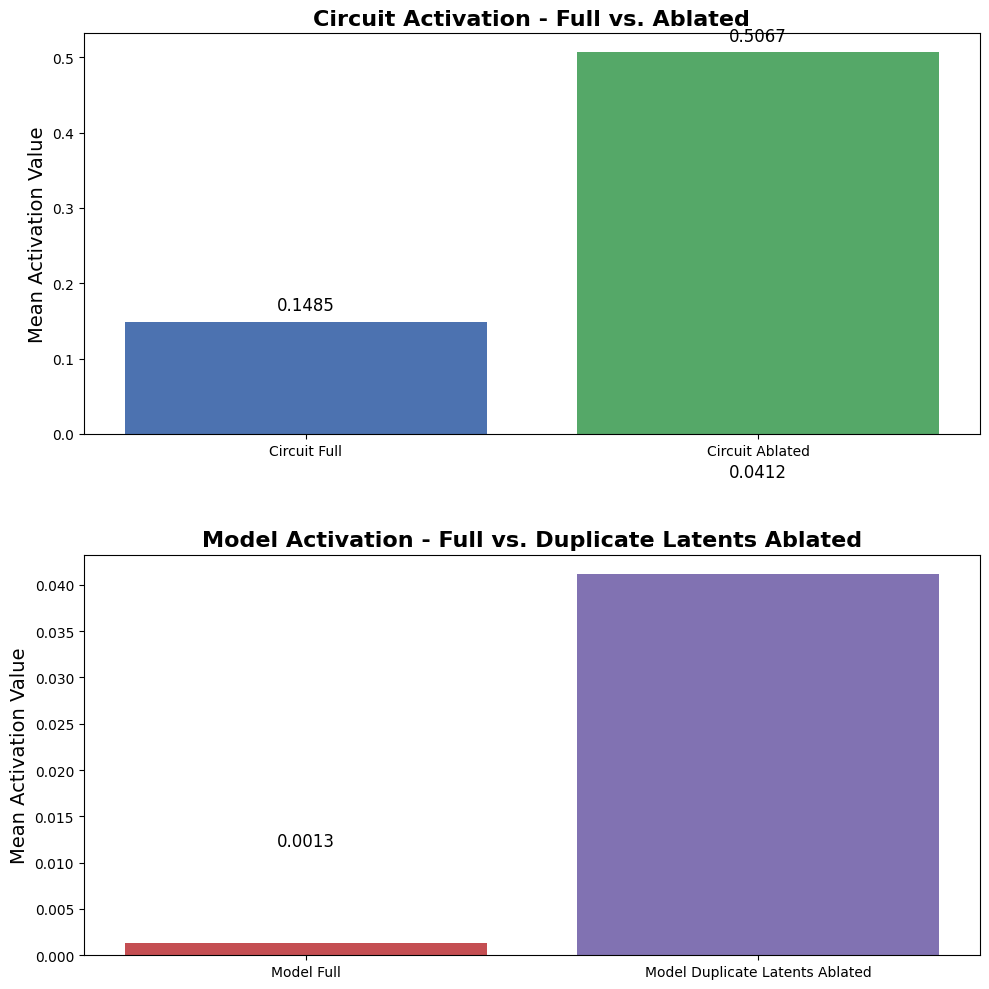

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Define labels for each set of bars
conditions_group1 = ['Circuit Full', 'Circuit Ablated']
values_group1 = [circuit_full, circuit_ablated]

conditions_group2 = ['Model Full', 'Model Duplicate Latents Ablated']
values_group2 = [model_full, model_dup_ablated]

# Set up subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Bar plot for Group 1
ax1.bar(conditions_group1, values_group1, color=['#4C72B0', '#55A868'])
ax1.set_title("Circuit Activation - Full vs. Ablated", fontsize=16, weight='bold')
ax1.set_ylabel("Mean Activation Value", fontsize=14)
for i, v in enumerate(values_group1):
    ax1.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=12)

# Bar plot for Group 2
ax2.bar(conditions_group2, values_group2, color=['#C44E52', '#8172B2'])
ax2.set_title("Model Activation - Full vs. Duplicate Latents Ablated", fontsize=16, weight='bold')
ax2.set_ylabel("Mean Activation Value", fontsize=14)
for i, v in enumerate(values_group2):
    ax2.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=12)

# Improve layout and display the plots
plt.tight_layout()
plt.show()

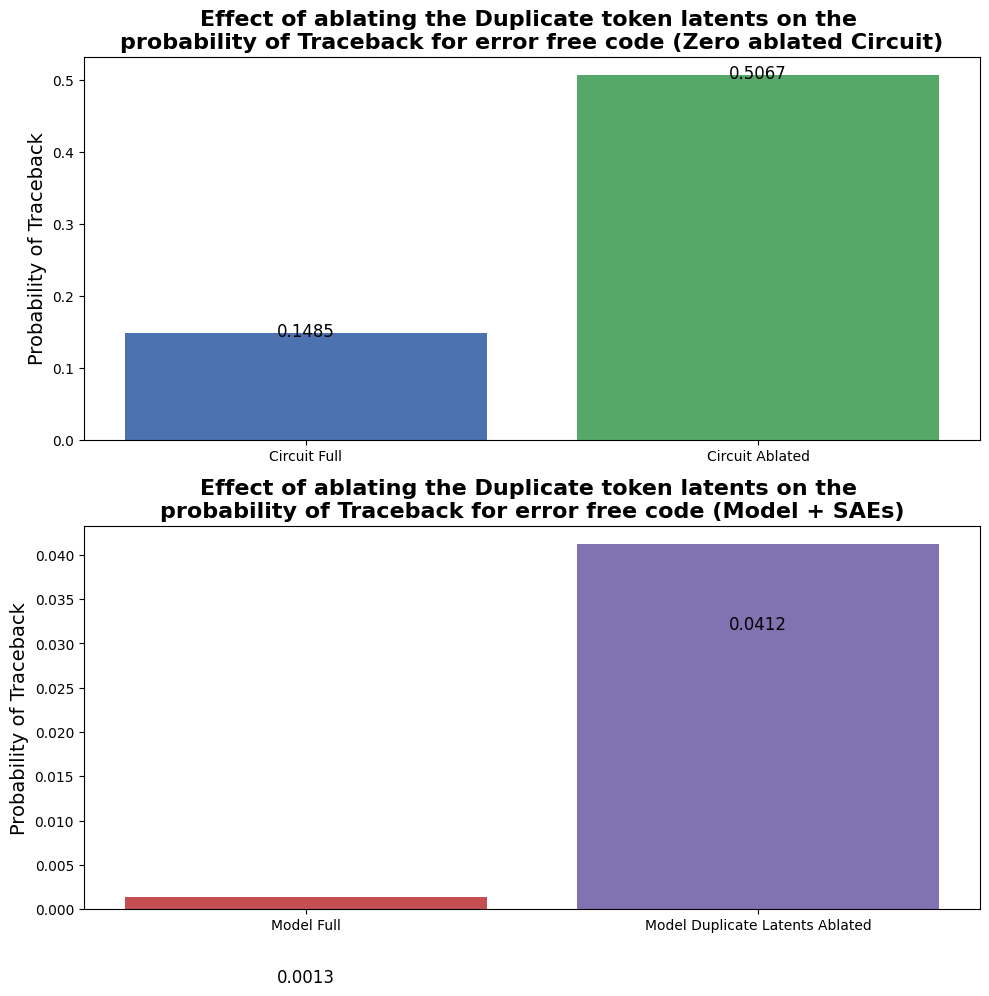

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define labels for each set of bars
conditions_group1 = ['Circuit Full', 'Circuit Ablated']
values_group1 = [circuit_full, circuit_ablated]

conditions_group2 = ['Model Full', 'Model Duplicate Latents Ablated']
values_group2 = [model_full, model_dup_ablated]

# Set up subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Bar plot for Group 1
ax1.bar(conditions_group1, values_group1, color=['#4C72B0', '#55A868'])
ax1.set_title("Effect of ablating the Duplicate token latents on the \nprobability of Traceback for error free code (Zero ablated Circuit)", fontsize=16, weight='bold')
ax1.set_ylabel("Probability of Traceback", fontsize=14)
for i, v in enumerate(values_group1):
    ax1.text(i, v - 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=12)

# Bar plot for Group 2
ax2.bar(conditions_group2, values_group2, color=['#C44E52', '#8172B2'])
ax2.set_title("Effect of ablating the Duplicate token latents on the \nprobability of Traceback for error free code (Model + SAEs)", fontsize=16, weight='bold')
ax2.set_ylabel("Probability of Traceback", fontsize=14)
for i, v in enumerate(values_group2):
    ax2.text(i, v - 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=12)

# Improve layout and display the plots
plt.tight_layout()
plt.show()

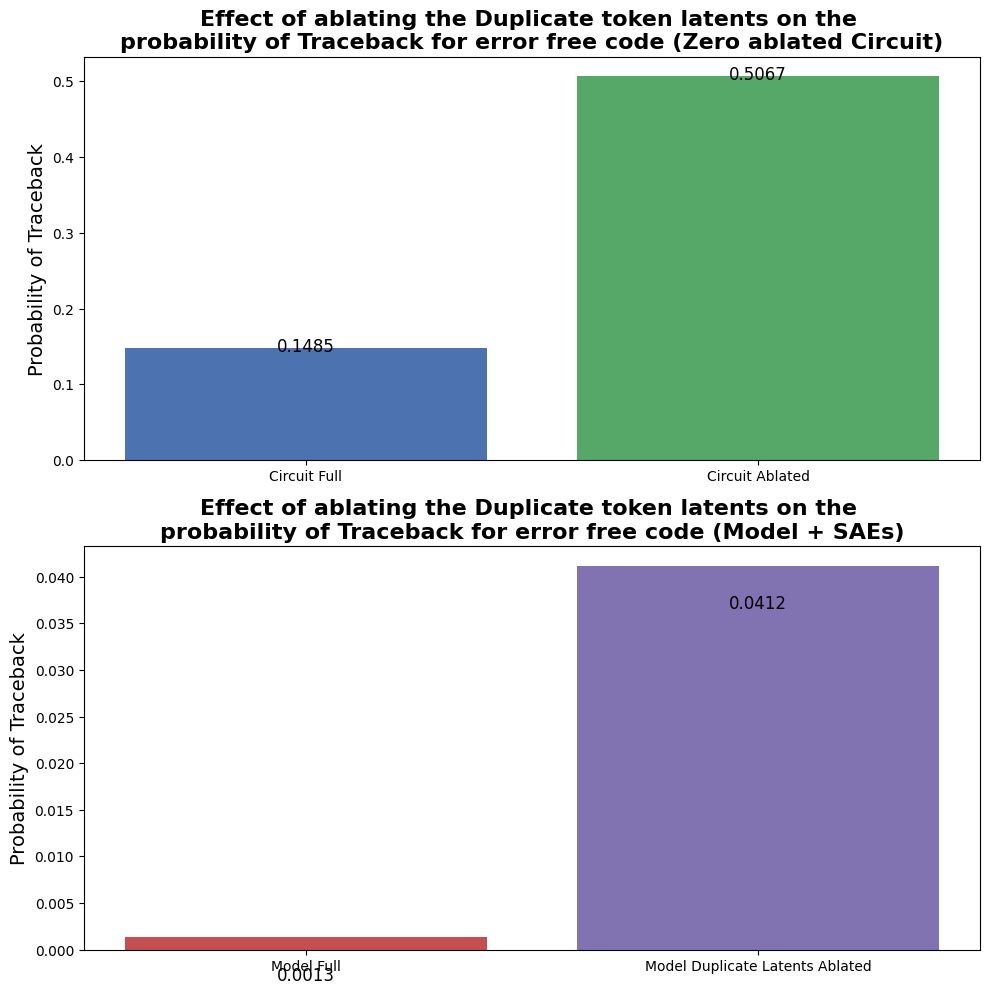

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Define labels for each set of bars
conditions_group1 = ['Circuit Full', 'Circuit Ablated']
values_group1 = [circuit_full, circuit_ablated]

conditions_group2 = ['Model Full', 'Model Duplicate Latents Ablated']
values_group2 = [model_full, model_dup_ablated]

# Set up subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Bar plot for Group 1
ax1.bar(conditions_group1, values_group1, color=['#4C72B0', '#55A868'])
ax1.set_title("Effect of ablating the Duplicate token latents on the \nprobability of Traceback for error free code (Zero ablated Circuit)", fontsize=16, weight='bold')
ax1.set_ylabel("Probability of Traceback", fontsize=14)
for i, v in enumerate(values_group1):
    ax1.text(i, v - 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=12)

# Bar plot for Group 2
ax2.bar(conditions_group2, values_group2, color=['#C44E52', '#8172B2'])
ax2.set_title("Effect of ablating the Duplicate token latents on the \nprobability of Traceback for error free code (Model + SAEs)", fontsize=16, weight='bold')
ax2.set_ylabel("Probability of Traceback", fontsize=14)
for i, v in enumerate(values_group2):
    ax2.text(i, v - 0.005, f"{v:.4f}", ha='center', va='bottom', fontsize=12)

# Improve layout and display the plots
plt.tight_layout()
plt.show()

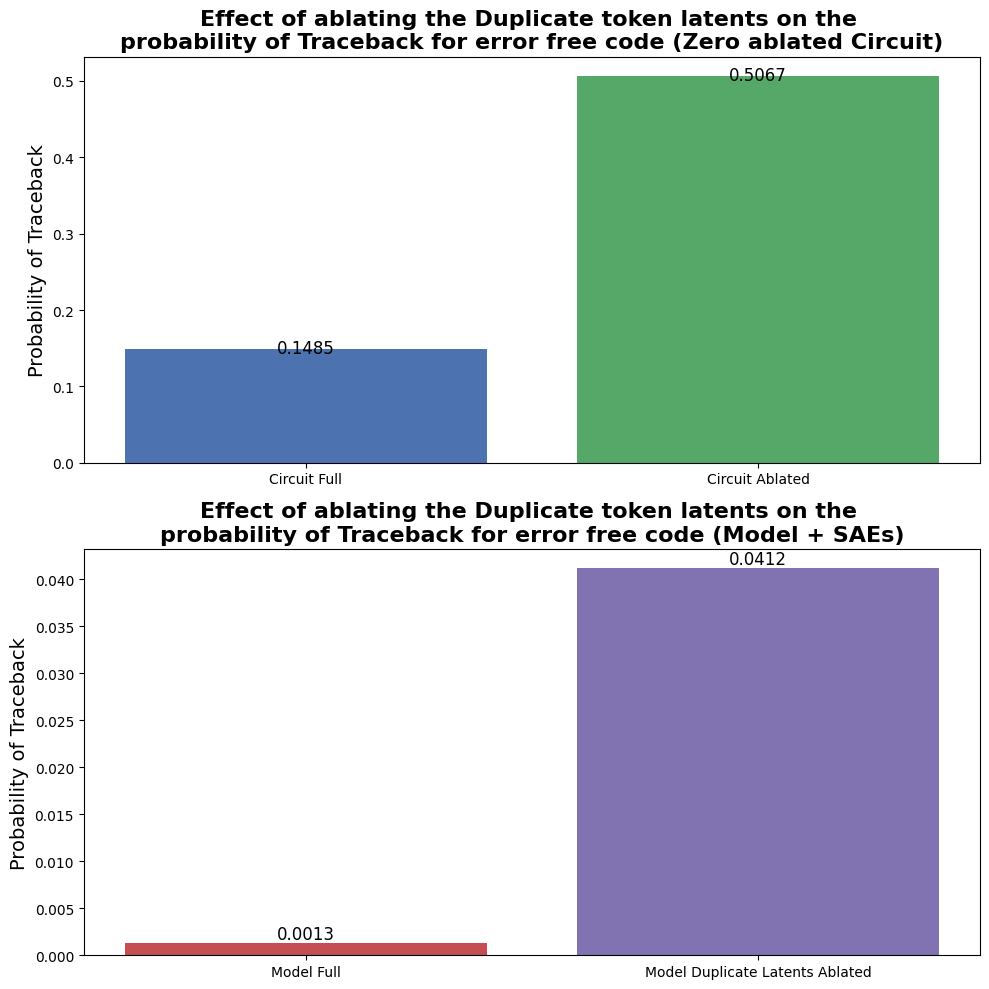

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Define labels for each set of bars
conditions_group1 = ['Circuit Full', 'Circuit Ablated']
values_group1 = [circuit_full, circuit_ablated]

conditions_group2 = ['Model Full', 'Model Duplicate Latents Ablated']
values_group2 = [model_full, model_dup_ablated]

# Set up subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Bar plot for Group 1
ax1.bar(conditions_group1, values_group1, color=['#4C72B0', '#55A868'])
ax1.set_title("Effect of ablating the Duplicate token latents on the \nprobability of Traceback for error free code (Zero ablated Circuit)", fontsize=16, weight='bold')
ax1.set_ylabel("Probability of Traceback", fontsize=14)
for i, v in enumerate(values_group1):
    ax1.text(i, v - 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=12)

# Bar plot for Group 2
ax2.bar(conditions_group2, values_group2, color=['#C44E52', '#8172B2'])
ax2.set_title("Effect of ablating the Duplicate token latents on the \nprobability of Traceback for error free code (Model + SAEs)", fontsize=16, weight='bold')
ax2.set_ylabel("Probability of Traceback", fontsize=14)
for i, v in enumerate(values_group2):
    ax2.text(i, v , f"{v:.4f}", ha='center', va='bottom', fontsize=12)

# Improve layout and display the plots
plt.tight_layout()
plt.show()

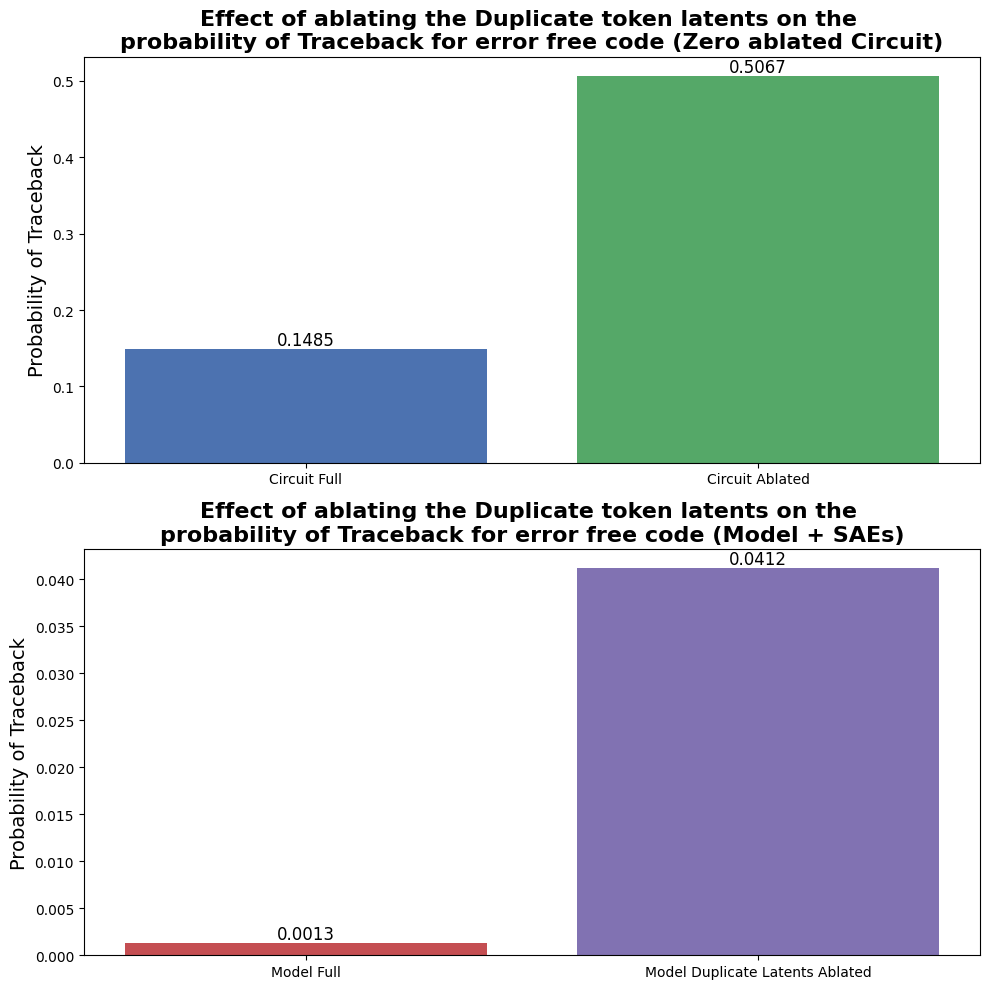

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Define labels for each set of bars
conditions_group1 = ['Circuit Full', 'Circuit Ablated']
values_group1 = [circuit_full, circuit_ablated]

conditions_group2 = ['Model Full', 'Model Duplicate Latents Ablated']
values_group2 = [model_full, model_dup_ablated]

# Set up subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Bar plot for Group 1
ax1.bar(conditions_group1, values_group1, color=['#4C72B0', '#55A868'])
ax1.set_title("Effect of ablating the Duplicate token latents on the \nprobability of Traceback for error free code (Zero ablated Circuit)", fontsize=16, weight='bold')
ax1.set_ylabel("Probability of Traceback", fontsize=14)
for i, v in enumerate(values_group1):
    ax1.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=12)

# Bar plot for Group 2
ax2.bar(conditions_group2, values_group2, color=['#C44E52', '#8172B2'])
ax2.set_title("Effect of ablating the Duplicate token latents on the \nprobability of Traceback for error free code (Model + SAEs)", fontsize=16, weight='bold')
ax2.set_ylabel("Probability of Traceback", fontsize=14)
for i, v in enumerate(values_group2):
    ax2.text(i, v , f"{v:.4f}", ha='center', va='bottom', fontsize=12)

# Improve layout and display the plots
plt.tight_layout()
plt.show()

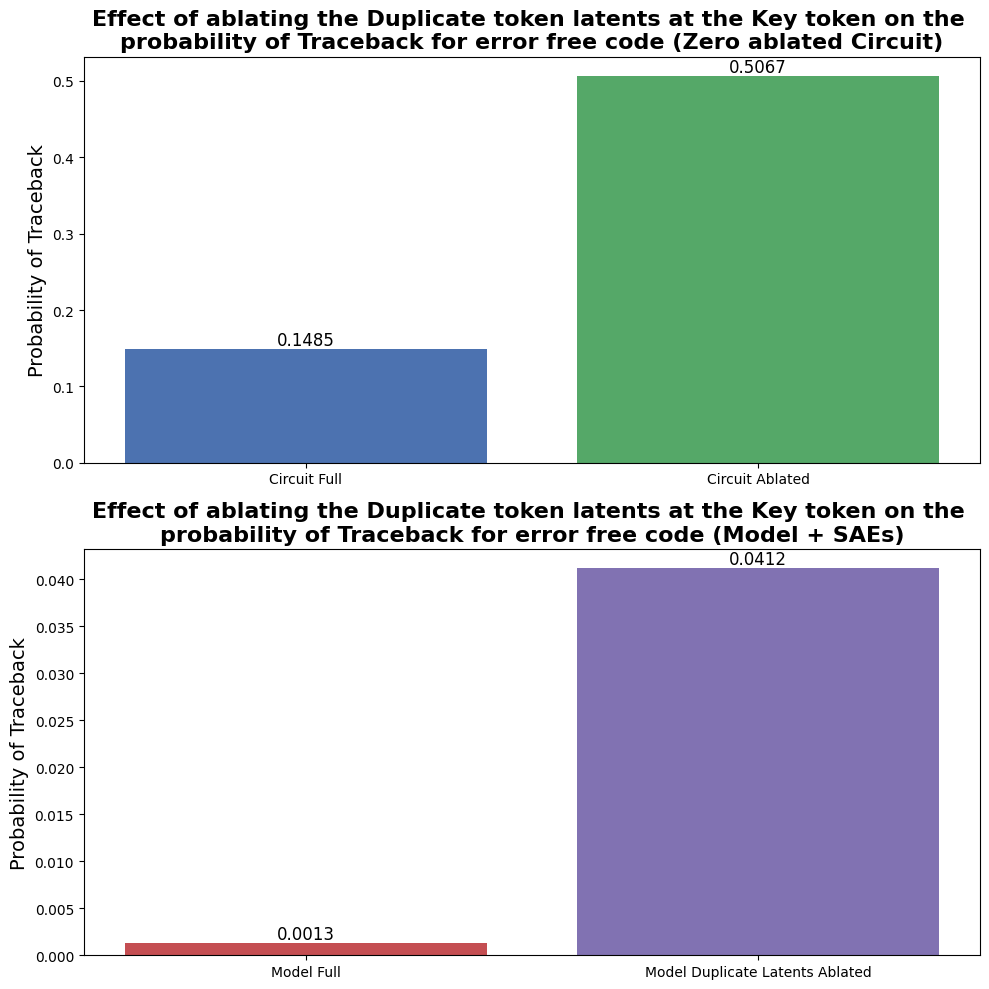

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Define labels for each set of bars
conditions_group1 = ['Circuit Full', 'Circuit Ablated']
values_group1 = [circuit_full, circuit_ablated]

conditions_group2 = ['Model Full', 'Model Duplicate Latents Ablated']
values_group2 = [model_full, model_dup_ablated]

# Set up subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Bar plot for Group 1
ax1.bar(conditions_group1, values_group1, color=['#4C72B0', '#55A868'])
ax1.set_title("Effect of ablating the Duplicate token latents at the Key token on the \nprobability of Traceback for error free code (Zero ablated Circuit)", fontsize=16, weight='bold')
ax1.set_ylabel("Probability of Traceback", fontsize=14)
for i, v in enumerate(values_group1):
    ax1.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=12)

# Bar plot for Group 2
ax2.bar(conditions_group2, values_group2, color=['#C44E52', '#8172B2'])
ax2.set_title("Effect of ablating the Duplicate token latents at the Key token on the \nprobability of Traceback for error free code (Model + SAEs)", fontsize=16, weight='bold')
ax2.set_ylabel("Probability of Traceback", fontsize=14)
for i, v in enumerate(values_group2):
    ax2.text(i, v , f"{v:.4f}", ha='center', va='bottom', fontsize=12)

# Improve layout and display the plots
plt.tight_layout()
plt.show()

In [33]:
def steering_hook(
    activations,
    hook,
    sae: SAE,
    latent_idx: int,
    steering_coefficient: float,
):
    """
    Steers the model by returning a modified activations tensor, with some multiple of the steering vector added to all
    sequence positions.
    """
    return activations + steering_coefficient * sae.W_dec[latent_idx]

# L7.9681, L14.14967,
_steering_hook = partial(
        steering_hook,
        sae=saes[0],
        latent_idx=10768,
        steering_coefficient=10,
    )
# model.add_sae(sae)
model.add_hook(saes[0].cfg.hook_name, _steering_hook, "fwd")
# model.add_hook(saes[0].cfg.hook_name, _steering_hook2, "fwd")
with torch.no_grad():
    logits = model(clean_tokens)
model.reset_hooks()
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
print("Log probability of 1: ", log_probs_answer.mean().item())
print("Log probability of Traceback: ", log_probs_traceback.mean().item())

Log probability of 1:  0.0010657650418579578
Log probability of Traceback:  0.9604302048683167


In [34]:
def steering_hook(
    activations,
    hook,
    sae: SAE,
    latent_idx: int,
    steering_coefficient: float,
):
    """
    Steers the model by returning a modified activations tensor, with some multiple of the steering vector added to all
    sequence positions.
    """
    return activations + steering_coefficient * sae.W_dec[latent_idx]

# L7.9681, L14.14967,
_steering_hook = partial(
        steering_hook,
        sae=saes[0],
        latent_idx=10768,
        steering_coefficient=80,
    )
# model.add_sae(sae)
model.add_hook(saes[0].cfg.hook_name, _steering_hook, "fwd")
# model.add_hook(saes[0].cfg.hook_name, _steering_hook2, "fwd")
with torch.no_grad():
    logits = model(clean_tokens)
model.reset_hooks()
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
print("Log probability of 1: ", log_probs_answer.mean().item())
print("Log probability of Traceback: ", log_probs_traceback.mean().item())

Log probability of 1:  0.2751704752445221
Log probability of Traceback:  0.45136526226997375


In [35]:
# Run the model without steering to get the base logits and log probabilities
with torch.no_grad():
    base_logits = model(clean_tokens)
    base_log_probs = base_logits.softmax(dim=-1)
    #torch.log_softmax(base_logits, dim=-1)
print(base_log_probs.shape)
# Get the top 5 tokens from the base log probabilities
top_5_token_indices = torch.topk(base_log_probs[1, -1], 5).indices  # Assuming single batch, last token position

print(f"Top 5 token indices: {top_5_token_indices}")
print(model.tokenizer.decode(top_5_token_indices))

torch.Size([50, 65, 256000])
Top 5 token indices: tensor([175843,  12914,  37160,   2469, 235303], device='cuda:0')
Traceback>>>SyntaxKey'


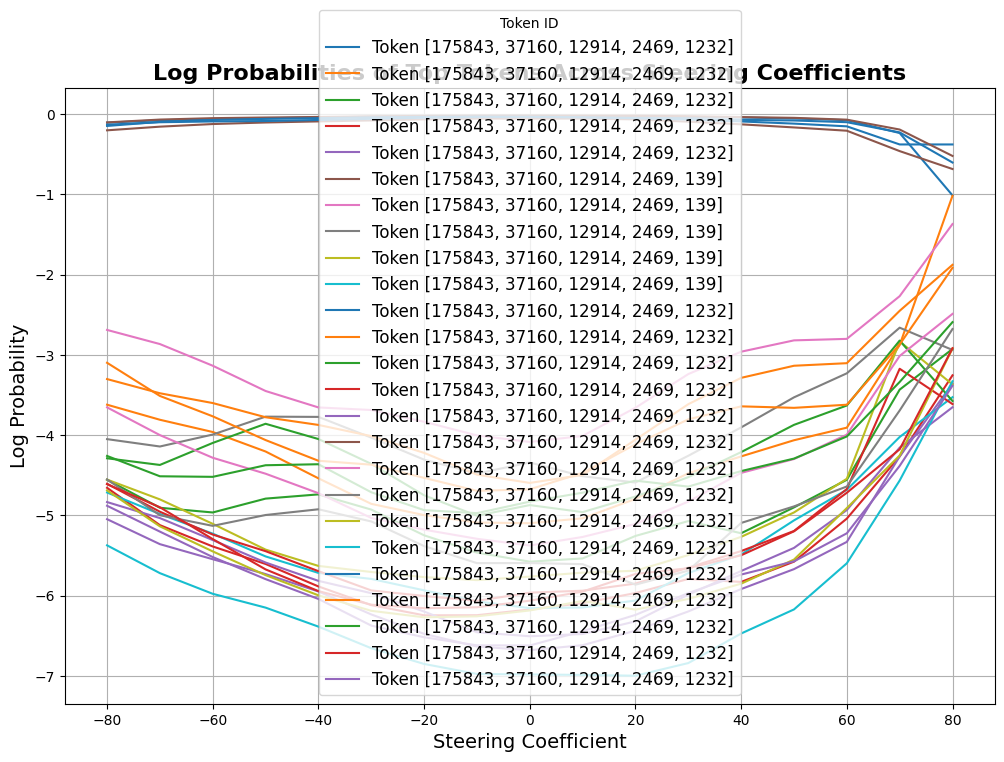

In [36]:
import torch
import matplotlib.pyplot as plt
from functools import partial

# Range of steering coefficients to sweep over
coeff_values = range(-80, 81, 10)
top_k = 5  # Number of top tokens to track

# Data structure to store top token probabilities for each coefficient
log_probs_top_tokens = {}

# Iterate over each steering coefficient
for coeff in coeff_values:
    # Define the steering hook with the current coefficient
    _steering_hook = partial(
        steering_hook,
        sae=saes[0],
        latent_idx=10768,
        steering_coefficient=coeff,
    )
    
    # Add the steering hook to the model
    model.add_hook(saes[0].cfg.hook_name, _steering_hook, "fwd")
    
    # Run the model with no gradient
    with torch.no_grad():
        logits = model(clean_tokens)
    
    # Reset hooks after running
    model.reset_hooks()
    
    # Calculate log probabilities
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    log_probs_last = log_probs[:, -1, :]  # Log probs of last token position

    # Get the top 5 tokens and their probabilities
    top_probs, top_tokens = torch.topk(log_probs_last, top_k, dim=-1)
    
    # Store the log probabilities of the top tokens for this coefficient
    log_probs_top_tokens[coeff] = {
        "tokens": top_tokens.squeeze().tolist(),
        "log_probs": top_probs.squeeze().tolist()
    }

# Plotting the log probabilities for the top tokens
plt.figure(figsize=(12, 8))

# Track top tokens across different coefficient values
for i in range(top_k):
    # Extract log probabilities for the ith top token across coefficients
    probs_for_token = [log_probs_top_tokens[coeff]["log_probs"][i] for coeff in coeff_values]
    token_id_for_label = log_probs_top_tokens[coeff_values[0]]["tokens"][i]
    
    # Plot the probabilities of this token across different coefficients
    plt.plot(coeff_values, probs_for_token, label=f'Token {token_id_for_label}')

# Plot settings
plt.title("Log Probabilities of Top Tokens Across Steering Coefficients", fontsize=16, weight='bold')
plt.xlabel("Steering Coefficient", fontsize=14)
plt.ylabel("Log Probability", fontsize=14)
plt.legend(title="Token ID", fontsize=12)
plt.grid(True)
plt.show()

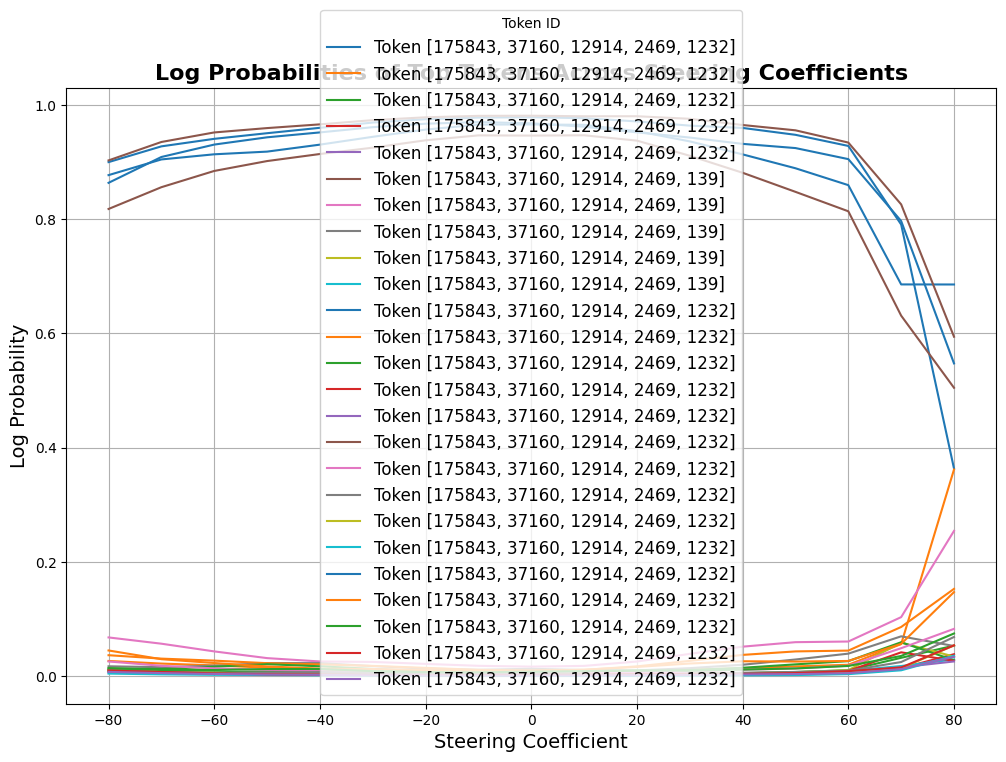

In [37]:
import torch
import matplotlib.pyplot as plt
from functools import partial

# Range of steering coefficients to sweep over
coeff_values = range(-80, 81, 10)
top_k = 5  # Number of top tokens to track

# Data structure to store top token probabilities for each coefficient
log_probs_top_tokens = {}

# Iterate over each steering coefficient
for coeff in coeff_values:
    # Define the steering hook with the current coefficient
    _steering_hook = partial(
        steering_hook,
        sae=saes[0],
        latent_idx=10768,
        steering_coefficient=coeff,
    )
    
    # Add the steering hook to the model
    model.add_hook(saes[0].cfg.hook_name, _steering_hook, "fwd")
    
    # Run the model with no gradient
    with torch.no_grad():
        logits = model(clean_tokens)
    
    # Reset hooks after running
    model.reset_hooks()
    
    # Calculate log probabilities
    log_probs = torch.nn.functional.softmax(logits, dim=-1)
    log_probs_last = log_probs[:, -1, :]  # Log probs of last token position

    # Get the top 5 tokens and their probabilities
    top_probs, top_tokens = torch.topk(log_probs_last, top_k, dim=-1)
    
    # Store the log probabilities of the top tokens for this coefficient
    log_probs_top_tokens[coeff] = {
        "tokens": top_tokens.squeeze().tolist(),
        "log_probs": top_probs.squeeze().tolist()
    }

# Plotting the log probabilities for the top tokens
plt.figure(figsize=(12, 8))

# Track top tokens across different coefficient values
for i in range(top_k):
    # Extract log probabilities for the ith top token across coefficients
    probs_for_token = [log_probs_top_tokens[coeff]["log_probs"][i] for coeff in coeff_values]
    token_id_for_label = log_probs_top_tokens[coeff_values[0]]["tokens"][i]
    
    # Plot the probabilities of this token across different coefficients
    plt.plot(coeff_values, probs_for_token, label=f'Token {token_id_for_label}')

# Plot settings
plt.title("Log Probabilities of Top Tokens Across Steering Coefficients", fontsize=16, weight='bold')
plt.xlabel("Steering Coefficient", fontsize=14)
plt.ylabel("Log Probability", fontsize=14)
plt.legend(title="Token ID", fontsize=12)
plt.grid(True)
plt.show()

In [38]:
import torch
import matplotlib.pyplot as plt
from functools import partial

# Range of steering coefficients to sweep over
coeff_values = range(-80, 81, 10)
top_k = 5  # Number of top tokens to track

# Data structure to store top token probabilities for each coefficient
log_probs_data = {}

# Iterate over each steering coefficient
for coeff in coeff_values:
    # Define the steering hook with the current coefficient
    _steering_hook = partial(
        steering_hook,
        sae=saes[0],
        latent_idx=10768,
        steering_coefficient=coeff,
    )
    
    # Add the steering hook to the model
    model.add_hook(saes[0].cfg.hook_name, _steering_hook, "fwd")
    
    # Run the model with no gradient
    with torch.no_grad():
        logits = model(clean_tokens)
    
    # Reset hooks after running
    model.reset_hooks()
    
    # Calculate log probabilities
    log_probs = torch.nn.functional.softmax(logits, dim=-1)
    log_probs_last = log_probs[:, -1, :]  # Log probs of last token position

    # Get the top 5 tokens and their log probabilities
    top_probs, top_tokens = torch.topk(log_probs_last, top_k, dim=-1)
    
    # Store the token IDs and log probabilities for this coefficient
    log_probs_data[coeff] = {
        "tokens": top_tokens.squeeze().tolist(),
        "log_probs": top_probs.squeeze().tolist()
    }
print("Steering complete!")
# Prepare the plot
plt.figure(figsize=(12, 8))

# Map each token to its log probabilities across different coefficients
token_lines = {}

for coeff in coeff_values:
    tokens = log_probs_data[coeff]["tokens"]
    probs = log_probs_data[coeff]["log_probs"]
    
    # Plot each point for the current coefficient
    for i, token_id in enumerate(tokens):
        # Decode the token ID to text
        token_text = model.tokenizer.decode([token_id])
        
        # Initialize a line for each unique token if not already tracked
        if token_id not in token_lines:
            token_lines[token_id] = {
                "coeffs": [],
                "probs": [],
                "label": token_text
            }
        
        # Append the coefficient and log probability for this token
        token_lines[token_id]["coeffs"].append(coeff)
        token_lines[token_id]["probs"].append(probs[i])

# Plot each token's line across coefficients
for token_id, data in token_lines.items():
    plt.plot(data["coeffs"], data["probs"], marker='o', label=data["label"])

# Plot settings
plt.title("Log Probabilities of Top Tokens Across Steering Coefficients", fontsize=16, weight='bold')
plt.xlabel("Steering Coefficient", fontsize=14)
plt.ylabel("Log Probability", fontsize=14)
plt.legend(title="Token", fontsize=12)
plt.grid(True)
plt.show()

Steering complete!


TypeError: argument 'ids': 'list' object cannot be interpreted as an integer

<Figure size 1200x800 with 0 Axes>

In [39]:
log_probs_data

{-80: {'tokens': [[175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 12914, 2469, 139],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 2469, 12914, 1232],
   [175843, 37160, 2469, 12914, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 2469, 12914, 139],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 2469, 12914, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 2469, 12914, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 2469, 12914, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 2469, 12914, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 12914, 2469, 1232],
   [175843, 37160, 12914, 2469, 235303],
   [175843

In [40]:
import torch
import matplotlib.pyplot as plt
from functools import partial

# Range of steering coefficients to sweep over
coeff_values = range(-80, 81, 10)
top_k = 5  # Number of top tokens to track

# Data structure to store top token probabilities for each coefficient
log_probs_data = {}

# Iterate over each steering coefficient
for coeff in coeff_values:
    # Define the steering hook with the current coefficient
    _steering_hook = partial(
        steering_hook,
        sae=saes[0],
        latent_idx=10768,
        steering_coefficient=coeff,
    )
    
    # Add the steering hook to the model
    model.add_hook(saes[0].cfg.hook_name, _steering_hook, "fwd")
    
    # Run the model with no gradient
    with torch.no_grad():
        logits = model(clean_tokens)
    
    # Reset hooks after running
    model.reset_hooks()
    
    # Calculate log probabilities and mean over batch dimension
    log_probs = torch.nn.functional.softmax(logits, dim=-1).mean(dim=0)
    log_probs_last = log_probs[-1, :]  # Log probs of the last token position

    # Get the top 5 tokens and their log probabilities
    top_probs, top_tokens = torch.topk(log_probs_last, top_k)
    
    # Store the token IDs and log probabilities for this coefficient
    log_probs_data[coeff] = {
        "tokens": top_tokens.tolist(),
        "log_probs": top_probs.tolist()
    }
print(log_probs_data)

{-80: {'tokens': [175843, 37160, 12914, 2469, 1232], 'log_probs': [0.8818562030792236, 0.03603438287973404, 0.012279524467885494, 0.010007266886532307, 0.006419534329324961]}, -70: {'tokens': [175843, 37160, 12914, 2469, 1232], 'log_probs': [0.9156805276870728, 0.02665751613676548, 0.009819863364100456, 0.006986488122493029, 0.00486918818205595]}, -60: {'tokens': [175843, 37160, 12914, 2469, 1232], 'log_probs': [0.9299613237380981, 0.021859999746084213, 0.011030197143554688, 0.004993653390556574, 0.0039288559928536415]}, -50: {'tokens': [175843, 37160, 12914, 2469, 1232], 'log_probs': [0.9369619488716125, 0.017395228147506714, 0.014342417009174824, 0.003645640332251787, 0.003206541994586587]}, -40: {'tokens': [175843, 12914, 37160, 2469, 1232], 'log_probs': [0.9440208077430725, 0.015873461961746216, 0.01322526577860117, 0.002880559302866459, 0.0026175016537308693]}, -30: {'tokens': [175843, 12914, 37160, 2469, 235303], 'log_probs': [0.9522777199745178, 0.015085491351783276, 0.009951276

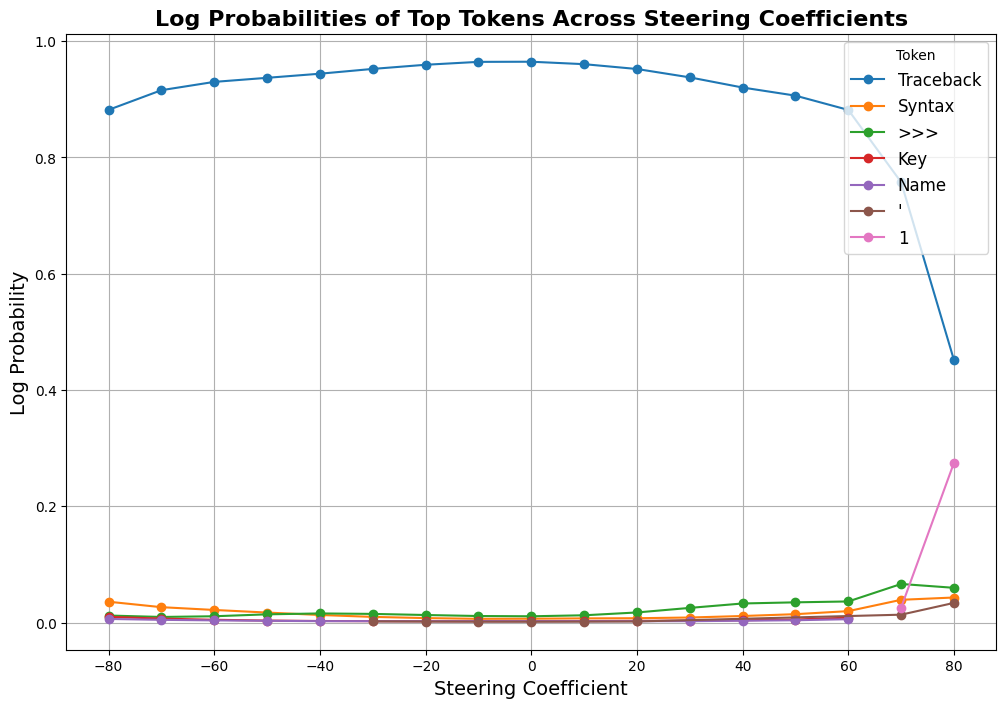

In [41]:
# Prepare the plot
plt.figure(figsize=(12, 8))

# Map each token to its log probabilities across different coefficients
token_lines = {}

for coeff in coeff_values:
    tokens = log_probs_data[coeff]["tokens"]
    probs = log_probs_data[coeff]["log_probs"]
    
    # Plot each point for the current coefficient
    for i, token_id in enumerate(tokens):
        # Decode the token ID to text
        token_text = model.tokenizer.decode([token_id])
        
        # Initialize a line for each unique token if not already tracked
        if token_id not in token_lines:
            token_lines[token_id] = {
                "coeffs": [],
                "probs": [],
                "label": token_text
            }
        
        # Append the coefficient and log probability for this token
        token_lines[token_id]["coeffs"].append(coeff)
        token_lines[token_id]["probs"].append(probs[i])

# Plot each token's line across coefficients
for token_id, data in token_lines.items():
    plt.plot(data["coeffs"], data["probs"], marker='o', label=data["label"])

# Plot settings
plt.title("Log Probabilities of Top Tokens Across Steering Coefficients", fontsize=16, weight='bold')
plt.xlabel("Steering Coefficient", fontsize=14)
plt.ylabel("Log Probability", fontsize=14)
plt.legend(title="Token", fontsize=12, loc="upper right")
plt.grid(True)
plt.show()

In [42]:
import torch
import matplotlib.pyplot as plt
from functools import partial

# Range of steering coefficients to sweep over
coeff_values = range(-30, 151, 30)
top_k = 5  # Number of top tokens to track

# Data structure to store top token probabilities for each coefficient
log_probs_data = {}

# Iterate over each steering coefficient
for coeff in coeff_values:
    # Define the steering hook with the current coefficient
    _steering_hook = partial(
        steering_hook,
        sae=saes[0],
        latent_idx=10768,
        steering_coefficient=coeff,
    )
    
    # Add the steering hook to the model
    model.add_hook(saes[0].cfg.hook_name, _steering_hook, "fwd")
    
    # Run the model with no gradient
    with torch.no_grad():
        logits = model(clean_tokens)
    
    # Reset hooks after running
    model.reset_hooks()
    
    # Calculate log probabilities and mean over batch dimension
    log_probs = torch.nn.functional.softmax(logits, dim=-1).mean(dim=0)
    log_probs_last = log_probs[-1, :]  # Log probs of the last token position

    # Get the top 5 tokens and their log probabilities
    top_probs, top_tokens = torch.topk(log_probs_last, top_k)
    
    # Store the token IDs and log probabilities for this coefficient
    log_probs_data[coeff] = {
        "tokens": top_tokens.tolist(),
        "log_probs": top_probs.tolist()
    }
print(log_probs_data)

{-30: {'tokens': [175843, 12914, 37160, 2469, 235303], 'log_probs': [0.9522777199745178, 0.015085491351783276, 0.009951276704668999, 0.002550770528614521, 0.002233757171779871]}, 0: {'tokens': [175843, 12914, 37160, 2469, 235303], 'log_probs': [0.9646426439285278, 0.010997743345797062, 0.006818521302193403, 0.0025781721342355013, 0.001635785331018269]}, 30: {'tokens': [175843, 12914, 37160, 2469, 1232], 'log_probs': [0.9377344846725464, 0.02541487105190754, 0.008877189829945564, 0.0035395233426243067, 0.002551931655034423]}, 60: {'tokens': [175843, 12914, 37160, 2469, 1232], 'log_probs': [0.8817346096038818, 0.03648602217435837, 0.019861791282892227, 0.008595104329288006, 0.00598200922831893]}, 90: {'tokens': [235274, 175843, 235303, 12914, 235284], 'log_probs': [0.6075000166893005, 0.10381393134593964, 0.07670645415782928, 0.04233401268720627, 0.024422278627753258]}, 120: {'tokens': [12914, 732, 235281, 2492, 235274], 'log_probs': [0.827327311038971, 0.046831678599119186, 0.0138877257

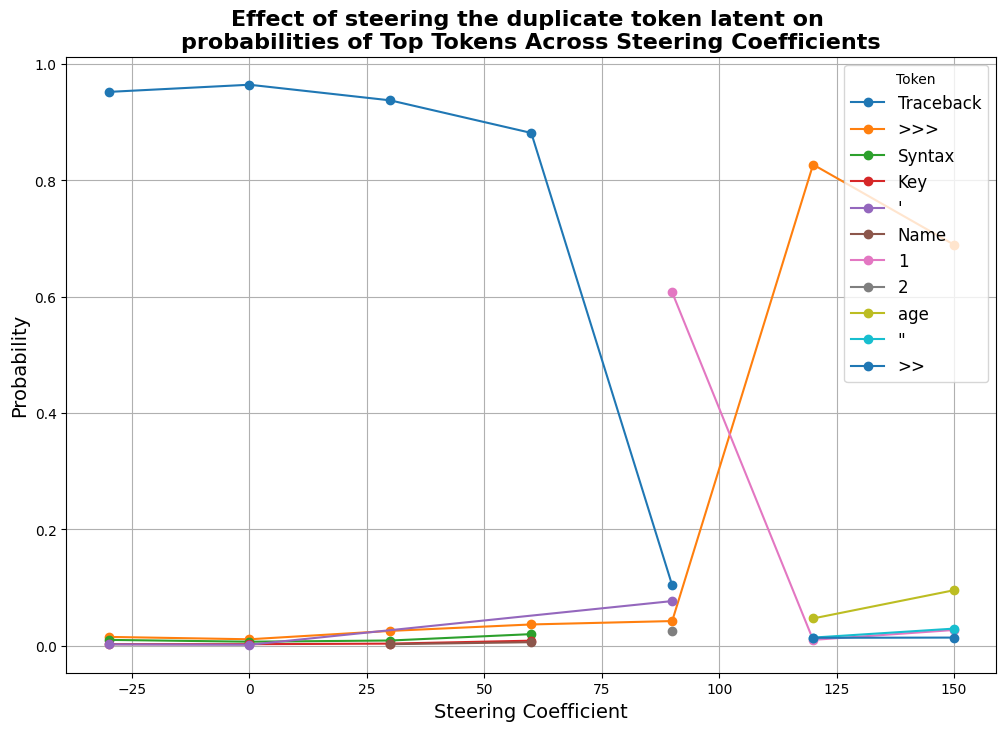

In [43]:
# Prepare the plot
plt.figure(figsize=(12, 8))

# Map each token to its log probabilities across different coefficients
token_lines = {}

for coeff in coeff_values:
    tokens = log_probs_data[coeff]["tokens"]
    probs = log_probs_data[coeff]["log_probs"]
    
    # Plot each point for the current coefficient
    for i, token_id in enumerate(tokens):
        # Decode the token ID to text
        token_text = model.tokenizer.decode([token_id])
        
        # Initialize a line for each unique token if not already tracked
        if token_id not in token_lines:
            token_lines[token_id] = {
                "coeffs": [],
                "probs": [],
                "label": token_text
            }
        
        # Append the coefficient and log probability for this token
        token_lines[token_id]["coeffs"].append(coeff)
        token_lines[token_id]["probs"].append(probs[i])

# Plot each token's line across coefficients
for token_id, data in token_lines.items():
    plt.plot(data["coeffs"], data["probs"], marker='o', label=data["label"])

# Plot settings
plt.title("Effect of steering the duplicate token latent on \nprobabilities of Top Tokens Across Steering Coefficients", fontsize=16, weight='bold')
plt.xlabel("Steering Coefficient", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(title="Token", fontsize=12, loc="upper right")
plt.grid(True)
plt.show()

In [44]:
import torch
import matplotlib.pyplot as plt
from functools import partial

# Range of steering coefficients to sweep over
coeff_values = range(-20, 121, 20)
top_k = 5  # Number of top tokens to track

# Data structure to store top token probabilities for each coefficient
log_probs_data = {}

# Iterate over each steering coefficient
for coeff in coeff_values:
    # Define the steering hook with the current coefficient
    _steering_hook = partial(
        steering_hook,
        sae=saes[0],
        latent_idx=10768,
        steering_coefficient=coeff,
    )
    
    # Add the steering hook to the model
    model.add_hook(saes[0].cfg.hook_name, _steering_hook, "fwd")
    
    # Run the model with no gradient
    with torch.no_grad():
        logits = model(clean_tokens)
    
    # Reset hooks after running
    model.reset_hooks()
    
    # Calculate log probabilities and mean over batch dimension
    log_probs = torch.nn.functional.softmax(logits, dim=-1).mean(dim=0)
    log_probs_last = log_probs[-1, :]  # Log probs of the last token position

    # Get the top 5 tokens and their log probabilities
    top_probs, top_tokens = torch.topk(log_probs_last, top_k)
    
    # Store the token IDs and log probabilities for this coefficient
    log_probs_data[coeff] = {
        "tokens": top_tokens.tolist(),
        "log_probs": top_probs.tolist()
    }
print(log_probs_data)

{-20: {'tokens': [175843, 12914, 37160, 2469, 235303], 'log_probs': [0.9594059586524963, 0.013184381648898125, 0.007898814044892788, 0.002448294311761856, 0.0019506517564877868]}, 0: {'tokens': [175843, 12914, 37160, 2469, 235303], 'log_probs': [0.9646426439285278, 0.010997743345797062, 0.006818521302193403, 0.0025781721342355013, 0.001635785331018269]}, 20: {'tokens': [175843, 12914, 37160, 2469, 235303], 'log_probs': [0.9521253108978271, 0.017560353502631187, 0.007670990657061338, 0.0031290727201849222, 0.0020385058596730232]}, 40: {'tokens': [175843, 12914, 37160, 2469, 1232], 'log_probs': [0.92025226354599, 0.03300788626074791, 0.011459803208708763, 0.004164720885455608, 0.0033543503377586603]}, 60: {'tokens': [175843, 12914, 37160, 2469, 1232], 'log_probs': [0.8817346096038818, 0.03648602217435837, 0.019861791282892227, 0.008595104329288006, 0.00598200922831893]}, 80: {'tokens': [175843, 235274, 12914, 37160, 235303], 'log_probs': [0.45136526226997375, 0.2751705050468445, 0.059939

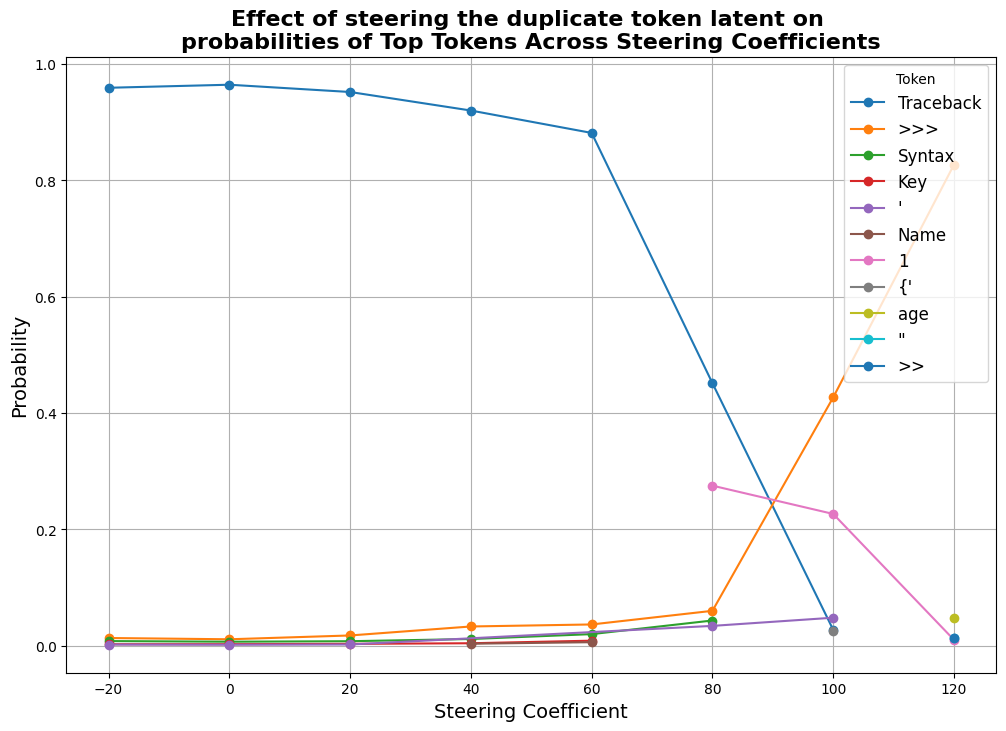

In [45]:
# Prepare the plot
plt.figure(figsize=(12, 8))

# Map each token to its log probabilities across different coefficients
token_lines = {}

for coeff in coeff_values:
    tokens = log_probs_data[coeff]["tokens"]
    probs = log_probs_data[coeff]["log_probs"]
    
    # Plot each point for the current coefficient
    for i, token_id in enumerate(tokens):
        # Decode the token ID to text
        token_text = model.tokenizer.decode([token_id])
        
        # Initialize a line for each unique token if not already tracked
        if token_id not in token_lines:
            token_lines[token_id] = {
                "coeffs": [],
                "probs": [],
                "label": token_text
            }
        
        # Append the coefficient and log probability for this token
        token_lines[token_id]["coeffs"].append(coeff)
        token_lines[token_id]["probs"].append(probs[i])

# Plot each token's line across coefficients
for token_id, data in token_lines.items():
    plt.plot(data["coeffs"], data["probs"], marker='o', label=data["label"])

# Plot settings
plt.title("Effect of steering the duplicate token latent on \nprobabilities of Top Tokens Across Steering Coefficients", fontsize=16, weight='bold')
plt.xlabel("Steering Coefficient", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(title="Token", fontsize=12, loc="upper right")
plt.grid(True)
plt.show()

In [46]:
import torch
import matplotlib.pyplot as plt
from functools import partial

# Range of steering coefficients to sweep over
coeff_values = range(-10, 111, 20)
top_k = 5  # Number of top tokens to track

# Data structure to store top token probabilities for each coefficient
log_probs_data = {}

# Iterate over each steering coefficient
for coeff in coeff_values:
    # Define the steering hook with the current coefficient
    _steering_hook = partial(
        steering_hook,
        sae=saes[0],
        latent_idx=10768,
        steering_coefficient=coeff,
    )
    
    # Add the steering hook to the model
    model.add_hook(saes[0].cfg.hook_name, _steering_hook, "fwd")
    
    # Run the model with no gradient
    with torch.no_grad():
        logits = model(clean_tokens)
    
    # Reset hooks after running
    model.reset_hooks()
    
    # Calculate log probabilities and mean over batch dimension
    log_probs = torch.nn.functional.softmax(logits, dim=-1).mean(dim=0)
    log_probs_last = log_probs[-1, :]  # Log probs of the last token position

    # Get the top 5 tokens and their log probabilities
    top_probs, top_tokens = torch.topk(log_probs_last, top_k)
    
    # Store the token IDs and log probabilities for this coefficient
    log_probs_data[coeff] = {
        "tokens": top_tokens.tolist(),
        "log_probs": top_probs.tolist()
    }
print(log_probs_data)

{-10: {'tokens': [175843, 12914, 37160, 2469, 235303], 'log_probs': [0.9643983244895935, 0.011440563015639782, 0.006614736281335354, 0.0024378576781600714, 0.0017205383628606796]}, 10: {'tokens': [175843, 12914, 37160, 2469, 235303], 'log_probs': [0.9604302644729614, 0.012700669467449188, 0.007388969883322716, 0.0028206289280205965, 0.0017640372971072793]}, 30: {'tokens': [175843, 12914, 37160, 2469, 1232], 'log_probs': [0.9377344846725464, 0.02541487105190754, 0.008877189829945564, 0.0035395233426243067, 0.002551931655034423]}, 50: {'tokens': [175843, 12914, 37160, 2469, 1232], 'log_probs': [0.9063097238540649, 0.03497646376490593, 0.014617608860135078, 0.005428362172096968, 0.004173059482127428]}, 70: {'tokens': [175843, 12914, 37160, 235274, 235303], 'log_probs': [0.7574213743209839, 0.06654989719390869, 0.039337076246738434, 0.026000864803791046, 0.013741953298449516]}, 90: {'tokens': [235274, 175843, 235303, 12914, 235284], 'log_probs': [0.6075000166893005, 0.10381393134593964, 0.

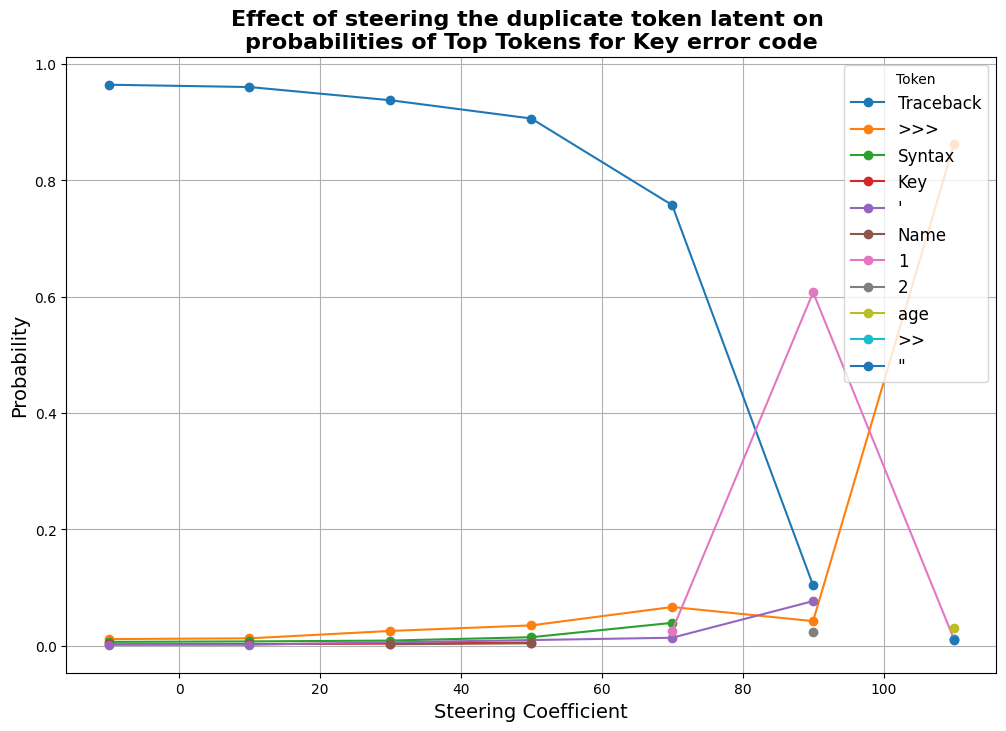

In [47]:
# Prepare the plot
plt.figure(figsize=(12, 8))

# Map each token to its log probabilities across different coefficients
token_lines = {}

for coeff in coeff_values:
    tokens = log_probs_data[coeff]["tokens"]
    probs = log_probs_data[coeff]["log_probs"]
    
    # Plot each point for the current coefficient
    for i, token_id in enumerate(tokens):
        # Decode the token ID to text
        token_text = model.tokenizer.decode([token_id])
        
        # Initialize a line for each unique token if not already tracked
        if token_id not in token_lines:
            token_lines[token_id] = {
                "coeffs": [],
                "probs": [],
                "label": token_text
            }
        
        # Append the coefficient and log probability for this token
        token_lines[token_id]["coeffs"].append(coeff)
        token_lines[token_id]["probs"].append(probs[i])

# Plot each token's line across coefficients
for token_id, data in token_lines.items():
    plt.plot(data["coeffs"], data["probs"], marker='o', label=data["label"])

# Plot settings
plt.title("Effect of steering the duplicate token latent on \nprobabilities of Top Tokens for Key error code", fontsize=16, weight='bold')
plt.xlabel("Steering Coefficient", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(title="Token", fontsize=12, loc="upper right")
plt.grid(True)
plt.show()

In [48]:
clean_prompts[0]

'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {\'James\': 17, \'Benjamin\': 15, \'Emma\': 13, \'Jackson\': 15, \'Mia\': 13}\n>>> age["Bob"]\n'

In [49]:
print(clean_prompts[0])

Type "help", "copyright", "credits" or "license" for more information.
>>> age = {'James': 17, 'Benjamin': 15, 'Emma': 13, 'Jackson': 15, 'Mia': 13}
>>> age["Bob"]



In [50]:
import random
import pandas as pd

# Sample names and values
names = ["James", "Benjamin", "Emma", "Jackson", "Mia", "Olivia", "Liam", "Sophia"]
ages = [13, 15, 17, 18, 20]
hobbies = ["reading", "swimming", "hiking", "dancing", "coding"]

# Templates for dictionary and non-dictionary structures
dict_template = "{var} = {{{pairs}}}"
list_template = "{var} = [{items}]"
string_template = "{var} = '{string}'"

# Generate a random variable name
def random_var_name():
    return random.choice(["age", "name", "height", "weight", "interest"])

# Generate a random dictionary structure
def generate_dict():
    var_name = random_var_name()
    pairs = ', '.join(f"'{random.choice(names)}': {random.choice(ages)}" for _ in range(3))
    return dict_template.format(var=var_name, pairs=pairs), 1

# Generate a random list or string structure
def generate_non_dict():
    var_name = random_var_name()
    structure_type = random.choice(["list", "string"])
    
    if structure_type == "list":
        items = ', '.join(f"'{random.choice(names)}'" for _ in range(3))
        return list_template.format(var=var_name, items=items), 0
    else:
        string = random.choice(hobbies)
        return string_template.format(var=var_name, string=string), 0

# Generate dataset
def generate_dataset(n_samples):
    data = []
    for _ in range(n_samples):
        if random.random() > 0.5:
            sample, label = generate_dict()
        else:
            sample, label = generate_non_dict()
        data.append({"text": sample, "label": label})
    return pd.DataFrame(data)

# Generate a dataset with N samples
N = 20
dataset = generate_dataset(N)
print(dataset)

                                                 text  label
0   interest = {'Benjamin': 17, 'Emma': 13, 'Emma'...      1
1   interest = {'Jackson': 13, 'Emma': 20, 'Benjam...      1
2                 age = ['Sophia', 'James', 'Sophia']      0
3   interest = {'Olivia': 15, 'Benjamin': 13, 'Sop...      1
4               weight = ['Sophia', 'Mia', 'Jackson']      0
5                                   height = 'hiking'      0
6          weight = ['Olivia', 'Benjamin', 'Jackson']      0
7   name = {'Jackson': 20, 'Jackson': 17, 'James':...      1
8                   height = ['Mia', 'Emma', 'James']      0
9                interest = ['Liam', 'James', 'Liam']      0
10                 name = ['Emma', 'Olivia', 'James']      0
11                 name = ['Emma', 'Liam', 'Jackson']      0
12              weight = ['James', 'Benjamin', 'Mia']      0
13                   height = ['Emma', 'Liam', 'Mia']      0
14          height = ['Jackson', 'Sophia', 'Jackson']      0
15  interest = {'Olivia'

In [51]:
index_helper_latents = {'blocks.7.hook_resid_post': [7008, 14309], 'blocks.14.hook_resid_post': [14864]}

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(index_helper_latents["blocks.7.hook_resid_post"]))
filtered_mask['blocks.14.hook_resid_post'] = list(set(mask['blocks.14.hook_resid_post']) - set(index_helper_latents["blocks.14.hook_resid_post"]))
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, filtered_mask)

log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, answer_token]
circuit_dup_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated: ", circuit_dup_ablated)

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, answer_token]
full_circuit_perf = log_probs.mean().detach().cpu().item()
print("Full circuit perf: ", full_circuit_perf)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated:  0.498960018157959
Full circuit perf:  0.7135378122329712


In [52]:
index_helper_latents = {'blocks.7.hook_resid_post': [7008, 14309], 'blocks.14.hook_resid_post': [14864]}

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(index_helper_latents["blocks.7.hook_resid_post"]))
filtered_mask['blocks.14.hook_resid_post'] = list(set(mask['blocks.14.hook_resid_post']) - set(index_helper_latents["blocks.14.hook_resid_post"]))
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, filtered_mask)

log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
circuit_dup_ablated_answer = log_probs.mean().detach().cpu().item()
circuit_dup_ablated_traceback = log_probs_traceback.mean().detach().cpu().item()
print("Duplicate cluster ablated: ", circuit_dup_ablated)
print("Duplicate cluster ablated, all latents: ",circuit_dup_ablated_answer)

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
full_circuit_perf = log_probs.mean().detach().cpu().item()
full_circuit_traceback = log_probs_traceback.mean().detach().cpu().item()
print("Full circuit perf: ", full_circuit_perf)
print("Full circuit perf: ", full_circuit_traceback)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated:  0.498960018157959
Duplicate cluster ablated, all latents:  3.90625064028427e-06
Full circuit perf:  3.90625064028427e-06
Full circuit perf:  0.14853711426258087


In [53]:
index_helper_latents = {'blocks.7.hook_resid_post': [7008, 14309], 'blocks.14.hook_resid_post': [14864]}

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(index_helper_latents["blocks.7.hook_resid_post"]))
filtered_mask['blocks.14.hook_resid_post'] = list(set(mask['blocks.14.hook_resid_post']) - set(index_helper_latents["blocks.14.hook_resid_post"]))
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, filtered_mask)

log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
circuit_dup_ablated_answer = log_probs_answer.mean().detach().cpu().item()
circuit_dup_ablated_traceback = log_probs_traceback.mean().detach().cpu().item()
print("Duplicate cluster ablated: ", circuit_dup_ablated)
print("Duplicate cluster ablated, all latents: ",circuit_dup_ablated_answer)

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
full_circuit_perf = log_probs_answer.mean().detach().cpu().item()
full_circuit_traceback = log_probs_traceback.mean().detach().cpu().item()
print("Full circuit perf: ", full_circuit_perf)
print("Full circuit perf: ", full_circuit_traceback)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated:  0.498960018157959
Duplicate cluster ablated, all latents:  0.498960018157959
Full circuit perf:  0.7135378122329712
Full circuit perf:  0.14853711426258087


In [54]:
index_helper_latents = {'blocks.7.hook_resid_post': [7008, 14309], 'blocks.14.hook_resid_post': [14864]}

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(index_helper_latents["blocks.7.hook_resid_post"]))
filtered_mask['blocks.14.hook_resid_post'] = list(set(mask['blocks.14.hook_resid_post']) - set(index_helper_latents["blocks.14.hook_resid_post"]))
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, filtered_mask)

log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
circuit_dup_ablated_answer = log_probs_answer.mean().detach().cpu().item()
circuit_dup_ablated_traceback = log_probs_traceback.mean().detach().cpu().item()
print("Duplicate cluster ablated: ", circuit_dup_ablated_answer)
print("Duplicate cluster ablated, all latents: ", circuit_dup_ablated_traceback)

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
full_circuit_perf = log_probs_answer.mean().detach().cpu().item()
full_circuit_traceback = log_probs_traceback.mean().detach().cpu().item()
print("Full circuit perf: ", full_circuit_perf)
print("Full circuit perf: ", full_circuit_traceback)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated:  0.498960018157959
Duplicate cluster ablated, all latents:  0.23807218670845032
Full circuit perf:  0.7135378122329712
Full circuit perf:  0.14853711426258087


In [55]:
# Helper function to get top 5 tokens and their probabilities
def get_top_5_tokens(logits, model, tokenizer):
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    log_probs_last = log_probs[:, -1, :]  # Log probs of the last token position (after averaging batch if necessary)
    top_probs, top_tokens = torch.topk(log_probs_last, 5, dim=-1)
    top_tokens = top_tokens.squeeze().tolist()
    top_probs = top_probs.squeeze().tolist()
    top_tokens_decoded = [tokenizer.decode([token]) for token in top_tokens]
    return list(zip(top_tokens_decoded, top_probs))

# Run the model for each condition and extract top 5 tokens
# Full circuit
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
top_5_full_circuit = get_top_5_tokens(logits, model, model.tokenizer)

# Duplicate cluster ablated
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, filtered_mask)
top_5_dup_ablated = get_top_5_tokens(logits, model, model.tokenizer)

# Print a side-by-side comparison of the top 5 tokens for each condition
from tabulate import tabulate

# Prepare the data for display
table_data = []
for i in range(5):
    table_data.append([
        top_5_full_circuit[i][0],  # Token from full circuit
        top_5_full_circuit[i][1],  # Probability from full circuit
        top_5_dup_ablated[i][0],   # Token from ablated circuit
        top_5_dup_ablated[i][1]    # Probability from ablated circuit
    ])

# Display the table
print(tabulate(
    table_data,
    headers=["Token (Full Circuit)", "Log Probability (Full Circuit)", "Token (Dup Ablated)", "Log Probability (Dup Ablated)"],
    tablefmt="pretty"
))

TypeError: argument 'ids': 'list' object cannot be interpreted as an integer

In [56]:
# Helper function to get top 5 tokens and their probabilities
def get_top_5_tokens(logits, model, tokenizer):
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    log_probs_last = log_probs[:, -1, :]  # Log probs of the last token position (after averaging batch if necessary)
    top_probs, top_tokens = torch.topk(log_probs_last, 5, dim=-1)
    top_tokens = top_tokens.squeeze().tolist()
    top_probs = top_probs.squeeze().tolist()
    top_tokens_decoded = [tokenizer.decode(token) for token in top_tokens]
    return list(zip(top_tokens_decoded, top_probs))

# Run the model for each condition and extract top 5 tokens
# Full circuit
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
top_5_full_circuit = get_top_5_tokens(logits, model, model.tokenizer)

# Duplicate cluster ablated
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, filtered_mask)
top_5_dup_ablated = get_top_5_tokens(logits, model, model.tokenizer)

# Print a side-by-side comparison of the top 5 tokens for each condition
from tabulate import tabulate

# Prepare the data for display
table_data = []
for i in range(5):
    table_data.append([
        top_5_full_circuit[i][0],  # Token from full circuit
        top_5_full_circuit[i][1],  # Probability from full circuit
        top_5_dup_ablated[i][0],   # Token from ablated circuit
        top_5_dup_ablated[i][1]    # Probability from ablated circuit
    ])

# Display the table
print(tabulate(
    table_data,
    headers=["Token (Full Circuit)", "Log Probability (Full Circuit)", "Token (Dup Ablated)", "Log Probability (Dup Ablated)"],
    tablefmt="pretty"
))

+-------------------------+----------------------------------------------------------------------------------------------------------+-----------------------+----------------------------------------------------------------------------------------------------------+
|  Token (Full Circuit)   |                                      Log Probability (Full Circuit)                                      |  Token (Dup Ablated)  |                                      Log Probability (Dup Ablated)                                       |
+-------------------------+----------------------------------------------------------------------------------------------------------+-----------------------+----------------------------------------------------------------------------------------------------------+
| 1Traceback2Exception>>> | [-0.5434631705284119, -1.3214669227600098, -3.4200406074523926, -4.071487903594971, -4.546057224273682]  | 1Traceback 2Exception | [-0.7519678473472595, -1.2420706748962402, 

In [57]:
# Helper function to get top 5 tokens and their mean log probabilities across batch dimension
def get_top_5_tokens(logits, model, tokenizer):
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1).mean(dim=0)  # Take mean over batch dimension
    log_probs_last = log_probs[-1, :]  # Log probs of the last token position
    top_probs, top_tokens = torch.topk(log_probs_last, 5)
    top_tokens = top_tokens.tolist()
    top_probs = top_probs.tolist()
    top_tokens_decoded = [tokenizer.decode([token]) for token in top_tokens]
    return list(zip(top_tokens_decoded, top_probs))

# Run the model for each condition and extract top 5 tokens
# Full circuit
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
top_5_full_circuit = get_top_5_tokens(logits, model, model.tokenizer)

# Duplicate cluster ablated
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, filtered_mask)
top_5_dup_ablated = get_top_5_tokens(logits, model, model.tokenizer)

# Print a side-by-side comparison of the top 5 tokens for each condition
from tabulate import tabulate

# Prepare the data for display
table_data = []
for i in range(5):
    table_data.append([
        top_5_full_circuit[i][0],  # Token from full circuit
        top_5_full_circuit[i][1],  # Probability from full circuit
        top_5_dup_ablated[i][0],   # Token from ablated circuit
        top_5_dup_ablated[i][1]    # Probability from ablated circuit
    ])

# Display the table
print(tabulate(
    table_data,
    headers=["Token (Full Circuit)", "Log Probability (Full Circuit)", "Token (Dup Ablated)", "Log Probability (Dup Ablated)"],
    tablefmt="pretty"
))

+----------------------+--------------------------------+---------------------+-------------------------------+
| Token (Full Circuit) | Log Probability (Full Circuit) | Token (Dup Ablated) | Log Probability (Dup Ablated) |
+----------------------+--------------------------------+---------------------+-------------------------------+
|          1           |       -0.33981853723526        |          1          |      -0.7098875045776367      |
|      Traceback       |      -1.9334805011749268       |      Traceback      |      -1.4770286083221436      |
|          2           |       -3.340965509414673       |                     |      -3.0953831672668457      |
|          3           |       -4.667271137237549       |          '          |      -3.6435985565185547      |
|                      |       -4.722275733947754       |          2          |      -3.779400587081909       |
+----------------------+--------------------------------+---------------------+-------------------------

In [58]:
# Helper function to get top 5 tokens and their mean log probabilities across batch dimension
def get_top_5_tokens(logits, model, tokenizer):
    log_probs = torch.nn.functional.softmax(logits, dim=-1).mean(dim=0)  # Take mean over batch dimension
    log_probs_last = log_probs[-1, :]  # Log probs of the last token position
    top_probs, top_tokens = torch.topk(log_probs_last, 5)
    top_tokens = top_tokens.tolist()
    top_probs = top_probs.tolist()
    top_tokens_decoded = [tokenizer.decode([token]) for token in top_tokens]
    return list(zip(top_tokens_decoded, top_probs))

# Run the model for each condition and extract top 5 tokens
# Full circuit
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
top_5_full_circuit = get_top_5_tokens(logits, model, model.tokenizer)

# Duplicate cluster ablated
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, filtered_mask)
top_5_dup_ablated = get_top_5_tokens(logits, model, model.tokenizer)

# Print a side-by-side comparison of the top 5 tokens for each condition
from tabulate import tabulate

# Prepare the data for display
table_data = []
for i in range(5):
    table_data.append([
        top_5_full_circuit[i][0],  # Token from full circuit
        top_5_full_circuit[i][1],  # Probability from full circuit
        top_5_dup_ablated[i][0],   # Token from ablated circuit
        top_5_dup_ablated[i][1]    # Probability from ablated circuit
    ])

# Display the table
print(tabulate(
    table_data,
    headers=["Token (Full Circuit)", "Log Probability (Full Circuit)", "Token (Dup Ablated)", "Log Probability (Dup Ablated)"],
    tablefmt="pretty"
))

+----------------------+--------------------------------+---------------------+-------------------------------+
| Token (Full Circuit) | Log Probability (Full Circuit) | Token (Dup Ablated) | Log Probability (Dup Ablated) |
+----------------------+--------------------------------+---------------------+-------------------------------+
|          1           |       0.7135378122329712       |          1          |      0.49896007776260376      |
|      Traceback       |      0.14853711426258087       |      Traceback      |      0.23807218670845032      |
|          2           |      0.03556936979293823       |                     |     0.049501121044158936      |
|          3           |      0.00949089601635933       |          '          |      0.0286558885127306       |
|                      |      0.009159336797893047      |          2          |      0.02335207164287567      |
+----------------------+--------------------------------+---------------------+-------------------------

In [59]:
# Display the table
print(tabulate(
    table_data,
    headers=["Token (Full Circuit)", "Probability (Full Circuit)", "Token (Bracket Ablated)", "Probability (Bracket Ablated)"],
    tablefmt="pretty"
))

+----------------------+----------------------------+-------------------------+-------------------------------+
| Token (Full Circuit) | Probability (Full Circuit) | Token (Bracket Ablated) | Probability (Bracket Ablated) |
+----------------------+----------------------------+-------------------------+-------------------------------+
|          1           |     0.7135378122329712     |            1            |      0.49896007776260376      |
|      Traceback       |    0.14853711426258087     |        Traceback        |      0.23807218670845032      |
|          2           |    0.03556936979293823     |                         |     0.049501121044158936      |
|          3           |    0.00949089601635933     |            '            |      0.0286558885127306       |
|                      |    0.009159336797893047    |            2            |      0.02335207164287567      |
+----------------------+----------------------------+-------------------------+-------------------------

In [60]:
import random
import pandas as pd

# Sample names and values
names = ["James", "Benjamin", "Emma", "Jackson", "Mia", "Olivia", "Liam", "Sophia"]
ages = [13, 15, 17, 18, 20]
hobbies = ["reading", "swimming", "hiking", "dancing", "coding"]

# Templates for dictionary and non-dictionary structures
dict_template = "{var} = {{{pairs}}}"
list_template = "{var} = [{items}]"
string_template = "{var} = '{string}'"

# Generate a random variable name
def random_var_name():
    return random.choice(["age", "name", "height", "weight", "interest"])

# Generate a random dictionary structure
def generate_dict():
    var_name = random_var_name()
    pairs = ', '.join(f"'{random.choice(names)}': {random.choice(ages)}" for _ in range(3))
    return dict_template.format(var=var_name, pairs=pairs), 1

# Generate a random list or string structure
def generate_non_dict():
    var_name = random_var_name()
    structure_type = random.choice(["list", "string"])
    
    if structure_type == "list":
        items = ', '.join(f"'{random.choice(names)}'" for _ in range(3))
        return list_template.format(var=var_name, items=items), 0
    else:
        string = random.choice(hobbies)
        return string_template.format(var=var_name, string=string), 0

# Generate dataset
def generate_dataset(n_samples):
    data = []
    for _ in range(n_samples):
        if random.random() > 0.5:
            sample, label = generate_dict()
        else:
            sample, label = generate_non_dict()
        data.append({"text": sample, "label": label})
    return pd.DataFrame(data)

# Generate a dataset with N samples
N = 20
dataset = generate_dataset(N)
print(dataset)

                                                 text  label
0     height = {'Liam': 17, 'Jackson': 20, 'Mia': 13}      1
1        height = {'Mia': 13, 'Mia': 17, 'James': 13}      1
2                  name = ['Emma', 'Emma', 'Jackson']      0
3       weight = {'Emma': 17, 'James': 18, 'Mia': 18}      1
4   height = {'Benjamin': 18, 'Emma': 15, 'Emma': 18}      1
5   weight = {'Benjamin': 20, 'Sophia': 15, 'Sophi...      1
6           name = {'Liam': 20, 'Mia': 13, 'Mia': 13}      1
7        name = {'Mia': 18, 'James': 15, 'James': 17}      1
8              age = ['Liam', 'Benjamin', 'Benjamin']      0
9                                 interest = 'coding'      0
10  weight = {'Benjamin': 15, 'Liam': 20, 'James':...      1
11  weight = {'Emma': 13, 'James': 17, 'Jackson': 20}      1
12   age = {'Sophia': 20, 'Jackson': 20, 'James': 15}      1
13                                 height = 'reading'      0
14      age = {'Benjamin': 13, 'Liam': 17, 'Mia': 17}      1
15                      

In [61]:
dataset[0]

KeyError: 0

In [62]:
dataset['text'][0]

"height = {'Liam': 17, 'Jackson': 20, 'Mia': 13}"

In [63]:
_, cache = run_with_saes_filtered_cache(dataset['text'], filtered_ids, model, saes)

ValueError: too many dimensions 'str'

In [64]:
probe_data = model.to_tokens(dataset['text'])
print(probe_data.shape)
_, cache = run_with_saes_filtered_cache(probe_data, filtered_ids, model, saes)

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [65]:
probe_data = model.to_tokens(dataset['text'].values)
print(probe_data.shape)
_, cache = run_with_saes_filtered_cache(probe_data, filtered_ids, model, saes)

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [66]:
dataset['text'].values

array(["height = {'Liam': 17, 'Jackson': 20, 'Mia': 13}",
       "height = {'Mia': 13, 'Mia': 17, 'James': 13}",
       "name = ['Emma', 'Emma', 'Jackson']",
       "weight = {'Emma': 17, 'James': 18, 'Mia': 18}",
       "height = {'Benjamin': 18, 'Emma': 15, 'Emma': 18}",
       "weight = {'Benjamin': 20, 'Sophia': 15, 'Sophia': 17}",
       "name = {'Liam': 20, 'Mia': 13, 'Mia': 13}",
       "name = {'Mia': 18, 'James': 15, 'James': 17}",
       "age = ['Liam', 'Benjamin', 'Benjamin']", "interest = 'coding'",
       "weight = {'Benjamin': 15, 'Liam': 20, 'James': 13}",
       "weight = {'Emma': 13, 'James': 17, 'Jackson': 20}",
       "age = {'Sophia': 20, 'Jackson': 20, 'James': 15}",
       "height = 'reading'",
       "age = {'Benjamin': 13, 'Liam': 17, 'Mia': 17}", "age = 'dancing'",
       "height = {'Liam': 18, 'Benjamin': 20, 'Mia': 15}",
       "height = ['Olivia', 'Emma', 'Olivia']",
       "interest = {'Jackson': 18, 'James': 20, 'Liam': 18}",
       "interest = ['Emma', 'J

In [67]:
list(dataset['text'].values)

["height = {'Liam': 17, 'Jackson': 20, 'Mia': 13}",
 "height = {'Mia': 13, 'Mia': 17, 'James': 13}",
 "name = ['Emma', 'Emma', 'Jackson']",
 "weight = {'Emma': 17, 'James': 18, 'Mia': 18}",
 "height = {'Benjamin': 18, 'Emma': 15, 'Emma': 18}",
 "weight = {'Benjamin': 20, 'Sophia': 15, 'Sophia': 17}",
 "name = {'Liam': 20, 'Mia': 13, 'Mia': 13}",
 "name = {'Mia': 18, 'James': 15, 'James': 17}",
 "age = ['Liam', 'Benjamin', 'Benjamin']",
 "interest = 'coding'",
 "weight = {'Benjamin': 15, 'Liam': 20, 'James': 13}",
 "weight = {'Emma': 13, 'James': 17, 'Jackson': 20}",
 "age = {'Sophia': 20, 'Jackson': 20, 'James': 15}",
 "height = 'reading'",
 "age = {'Benjamin': 13, 'Liam': 17, 'Mia': 17}",
 "age = 'dancing'",
 "height = {'Liam': 18, 'Benjamin': 20, 'Mia': 15}",
 "height = ['Olivia', 'Emma', 'Olivia']",
 "interest = {'Jackson': 18, 'James': 20, 'Liam': 18}",
 "interest = ['Emma', 'Jackson', 'Sophia']"]

In [68]:
probe_data = model.to_tokens(list(dataset['text'].values))
print(probe_data.shape)
_, cache = run_with_saes_filtered_cache(probe_data, filtered_ids, model, saes)

torch.Size([20, 24])


In [69]:
probe_data = model.to_tokens(list(dataset['text'].values))
print(probe_data.shape)
_, cache = run_with_saes_filtered_cache(probe_data, filtered_ids, model, saes)
relevant_latents = [1976, 6984, 7008, 7323, 10647]
# index the cache['blocks.7.hook_resid_post'] with relevant latents
relevant_cache = cache['blocks.7.hook_resid_post'][:, :, relevant_latents]
relevant_cache.shape

torch.Size([20, 24])


torch.Size([20, 24, 5])

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

probe_data = model.to_tokens(list(dataset['text'].values))

# Run model and filter the cache for the relevant activations
_, cache = run_with_saes_filtered_cache(probe_data, filtered_ids, model, saes)

# Extract the relevant activations for specific latents
# `relevant_cache` shape should be (batch, seq_len, len(relevant_latents))
relevant_latents = [1976, 6984, 7008, 7323, 10647]
relevant_cache = cache['blocks.7.hook_resid_post'][:, :, relevant_latents]  # Shape: (batch, seq_len, 5)

# Retrieve labels from the dataset
labels = torch.tensor(dataset['label'].values)  # Assuming labels are binary 0 or 1

# Define the linear probe model
class LinearProbe(nn.Module):
    def __init__(self, input_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        x = x.mean(dim=1)  # Mean pooling over seq_len
        return torch.sigmoid(self.linear(x)).squeeze(-1)

# Initialize the linear probe
input_dim = relevant_cache.shape[-1]  # 5 in this case, corresponding to relevant_latents
model = LinearProbe(input_dim)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(relevant_cache)
    loss = criterion(outputs, labels.float())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 35.0000
Epoch [2/10], Loss: 35.0000
Epoch [3/10], Loss: 35.0000
Epoch [4/10], Loss: 35.0000
Epoch [5/10], Loss: 35.0000
Epoch [6/10], Loss: 35.0000
Epoch [7/10], Loss: 35.0000
Epoch [8/10], Loss: 35.0000
Epoch [9/10], Loss: 35.0000
Epoch [10/10], Loss: 35.0000


In [71]:
import random
import pandas as pd

# Sample names and values
names = ["James", "Benjamin", "Emma", "Jackson", "Mia", "Olivia", "Liam", "Sophia"]
ages = [13, 15, 17, 18, 20]
hobbies = ["reading", "swimming", "hiking", "dancing", "coding"]

# Templates for dictionary and non-dictionary structures
dict_template = "{var} = {{{pairs}}}"
list_template = "{var} = [{items}]"
string_template = "{var} = '{string}'"

# Generate a random variable name
def random_var_name():
    return random.choice(["age", "name", "height", "weight", "interest"])

# Generate a random dictionary structure
def generate_dict():
    var_name = random_var_name()
    pairs = ', '.join(f"'{random.choice(names)}': {random.choice(ages)}" for _ in range(3))
    return dict_template.format(var=var_name, pairs=pairs), 1

# Generate a random list or string structure
def generate_non_dict():
    var_name = random_var_name()
    structure_type = random.choice(["list", "string"])
    
    if structure_type == "list":
        items = ', '.join(f"'{random.choice(names)}'" for _ in range(3))
        return list_template.format(var=var_name, items=items), 0
    else:
        string = random.choice(hobbies)
        return string_template.format(var=var_name, string=string), 0

# Generate dataset
def generate_dataset(n_samples):
    data = []
    for _ in range(n_samples):
        if random.random() > 0.5:
            sample, label = generate_dict()
        else:
            sample, label = generate_non_dict()
        data.append({"text": sample, "label": label})
    return pd.DataFrame(data)

# Generate a dataset with N samples
N = 1000
dataset = generate_dataset(N)
print(dataset)

                                                  text  label
0         height = ['Jackson', 'Benjamin', 'Benjamin']      0
1                                   weight = 'reading'      0
2    height = {'Jackson': 18, 'Liam': 20, 'Benjamin...      1
3      interest = {'Mia': 17, 'Mia': 13, 'Olivia': 18}      1
4         height = {'Mia': 20, 'Liam': 15, 'Liam': 20}      1
..                                                 ...    ...
995                 interest = ['Liam', 'Mia', 'Emma']      0
996       height = {'Liam': 17, 'Emma': 13, 'Mia': 17}      1
997   name = {'Jackson': 13, 'Olivia': 18, 'Liam': 15}      1
998                                    name = 'coding'      0
999  height = {'Benjamin': 20, 'Olivia': 15, 'Benja...      1

[1000 rows x 2 columns]


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Custom Dataset class to handle text and label data
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Generate batches of tokens and activations
def generate_activations_batch(batch_texts):
    # Convert text to tokens in batch
    probe_data = model.to_tokens(batch_texts)
    
    # Run model and retrieve cache
    _, cache = run_with_saes_filtered_cache(probe_data, filtered_ids, model, saes)
    
    # Extract relevant activations for specific latents
    relevant_latents = [1976, 6984, 7008, 7323, 10647]
    relevant_cache = cache['blocks.7.hook_resid_post'][:, :, relevant_latents]
    return relevant_cache  # Shape: (batch_size, seq_len, len(relevant_latents))

# Define the linear probe model
class LinearProbe(nn.Module):
    def __init__(self, input_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        x = x.mean(dim=1)  # Mean pooling over seq_len
        return torch.sigmoid(self.linear(x)).squeeze(-1)

# Initialize dataset, DataLoader, and model
texts = list(dataset['text'].values)
labels = list(dataset['label'].values)
text_dataset = TextDataset(texts, labels)
batch_size = 16  # Set batch size
data_loader = DataLoader(text_dataset, batch_size=batch_size, shuffle=True)

input_dim = len(relevant_latents)  # Number of relevant latents
model = LinearProbe(input_dim)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop with batching
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_texts, batch_labels in data_loader:
        # Generate activations for the batch
        batch_activations = generate_activations_batch(batch_texts)
        
        # Convert labels to tensor
        batch_labels = torch.tensor(batch_labels).float()
        
        # Forward pass
        outputs = model(batch_activations)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate batch loss
        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(data_loader):.4f}')

# After training, `model` can be used to classify the type of structure based on activations

AttributeError: 'LinearProbe' object has no attribute 'to_tokens'

In [73]:
import os
import gc
import torch
os.chdir("/work/pi_jensen_umass_edu/jnainani_umass_edu/CircuitAnalysisSAEs")
import json
from sae_lens import SAE, HookedSAETransformer
from circ4latents import data_gen
from functools import partial
import einops

# Function to manage CUDA memory and clean up
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()
# cleanup_cuda()
# Load the config
with open("config.json", 'r') as file:
   config = json.load(file)
token = config.get('huggingface_token', None)
os.environ["HF_TOKEN"] = token

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

hf_cache = "/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/huggingface_cache/hub"
os.environ["HF_HOME"] = hf_cache

# Load the model
model = HookedSAETransformer.from_pretrained("google/gemma-2-9b", device=device, cache_dir=hf_cache)

layers= [7, 14, 21, 40]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res-canonical", sae_id=f"layer_{layer}/width_16k/canonical", device=device)[0] for layer in layers]

Device: cuda


Loading checkpoint shards: 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]


Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [74]:
def run_with_saes_filtered_cache(tokens, filtered_ids, model, saes):
    with torch.no_grad():  # Global no_grad for performance
        
        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Equivalent to unsqueeze(-1)

        sae_outs = {}
        
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Apply torch.where only if mask_expanded has True values
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_outs


def run_with_saes_latent_op_patch(new_tokens, filtered_ids, model, saes, cache, dict_feats):
   # Ensure tokens are a torch.Tensor
   if not isinstance(new_tokens, torch.Tensor):
       new_tokens = torch.tensor(new_tokens).to(model.cfg.device)  # Move to the device of the model

   # Create a mask where True indicates positions to modify
   mask = torch.ones_like(new_tokens, dtype=torch.bool)
   for token_id in filtered_ids:
       mask &= new_tokens != token_id

   # Expand the mask once, so it matches the shape [batch_size, seq_len, 1]
   mask_expanded = mask.unsqueeze(-1)  # Expand to allow broadcasting
   mask_expanded = mask_expanded.to(model.cfg.device)  # Move the mask to the same device as the model
   # For each SAE, add the appropriate hook
   for sae in saes:
       hook_point = sae.cfg.hook_name

       # Define the filtered hook function (optimized)
       def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
           # Apply the SAE only where mask_expanded is True
           enc_sae = sae.encode(act)  # Call the SAE once
          
           if hook.name in cache and hook.name in dict_feats:
               prev_sae = cache[hook.name].to(device)   # Get cached activations from the cache
               feature_indices = dict_feats[hook.name]  # Get the feature indices to patch

               for feature_idx in range(sae.cfg.d_sae):
                   if feature_idx in feature_indices:
                       enc_sae[:, :, feature_idx] = prev_sae[:, :, feature_idx]

           # After patching, decode the modified enc_sae
           modified_act = sae.decode(enc_sae)

           # In-place update where the mask is True
           updated_act = torch.where(mask_expanded, modified_act, act)

           return updated_act

       # Add the hook to the model
       model.add_hook(hook_point, filtered_hook, dir='fwd')

   # Run the model with the tokens (no gradients needed)
   with torch.no_grad():
       logits = model(new_tokens)

   # Reset the hooks after computation to free memory
   model.reset_hooks()

   return logits  # Return only the logits

def run_with_saes_latent_op_patch_cache(new_tokens, filtered_ids, model, saes, cache, dict_feats):
    with torch.no_grad():  # Global no_grad for efficiency

        # Ensure new_tokens is a tensor on the correct device
        new_tokens = torch.as_tensor(new_tokens, device=model.cfg.device)
        
        # Create mask in a vectorized way
        mask = ~torch.isin(new_tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Expand dimensions directly
        
        # Cache hook names and feature indices outside the hook
        sae_hook_configs = [(sae.cfg.hook_name, sae, dict_feats.get(sae.cfg.hook_name, [])) for sae in saes]
        sae_outs = {}

        # Define and apply hooks
        for hook_name, sae, feature_indices in sae_hook_configs:
            def filtered_hook(act, hook, sae=sae, feature_indices=feature_indices, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                if hook.name in cache and feature_indices:
                    # Vectorized update of selected feature indices
                    enc_sae[:, :, feature_indices] = cache[hook.name][:, :, feature_indices].to(device) 

                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Only apply torch.where if needed
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_name, filtered_hook, dir='fwd')

        logits = model(new_tokens)
        model.reset_hooks()

    return logits, sae_outs
    
def run_with_saes_zero_ablation(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]

        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0

                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits


def run_with_saes_zero_ablation_cache(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out


def run_with_saes_zero_ablation_cache_tokens(tokens, filtered_ids, model, saes, dict_feats, token_pos):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    # Zero out only at specified token positions
                    for pos in token_pos:
                        enc_sae[:, pos, zero_indices] = 0
                    # enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out


def run_with_saes_zero_ablation_cache_tokens_separate(tokens, filtered_ids, model, saes, dict_feats, dict_feats_v2, token_pos):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    feature_indices_v2 = dict_feats_v2[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)

                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]

                    enc_sae[:, :, zero_indices] = 0

                    zero_indices_v2 = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices_v2, device=model.cfg.device))]
                    # Zero out only at specified token positions
                    if feature_indices_v2:
                        for pos in token_pos:
                            enc_sae[:, pos, zero_indices_v2] = 0
                    
                    # enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out

In [75]:
cleanup_cuda()

In [76]:
import random
import pandas as pd

# Sample names and values
names = [
    "Bob", "Sam", "Lilly", "Rob", "Alice", "Charlie", "Sally", "Tom", "Jake", "Emily", 
    "Megan", "Chris", "Sophia", "James", "Oliver", "Isabella", "Mia", "Jackson", 
    "Emma", "Ava", "Lucas", "Benjamin", "Ethan", "Grace", "Olivia", "Liam", "Noah"
]
# ages = [13, 15, 17, 18, 20]
attributes = [
    "age", "name", "height", "weight", "interest", "gender", "occupation", "nationality",
    "marital_status", "education_level", "income", "languages_spoken", "place_of_birth",
    "eye_color", "hair_color", "blood_type", "allergies", "personality_traits",
    "favorite_color", "favorite_food", "relationship_status", "zodiac_sign",
    "social_media_handles", "hometown", "current_residence", "education_institution",
    "favorite_book", "favorite_movie", "favorite_music_genre", "favorite_sport", "pet_ownership"
]

# Expanded Hobbies List
hobbies = [
    "reading", "swimming", "hiking", "dancing", "coding", "painting", "traveling", "writing",
    "cooking", "gardening", "biking", 
    "yoga", "photography", "crafting", "fishing", "drawing", "knitting", "camping", "scuba_diving",
    "surfing", "volunteering"
]
# Templates for dictionary and non-dictionary structures
dict_template = "{var} = {{{pairs}}}"
list_template = "{var} = [{items}]"
string_template = "{var} = '{string}'"

# Generate a random variable name
def random_var_name():
    return random.choice(attributes)

# Generate a random dictionary structure
def generate_dict():
    var_name = random_var_name()
    pairs = ', '.join(f"'{random.choice(names)}': {random.randint(0, 99)}" for _ in range(3))
    return dict_template.format(var=var_name, pairs=pairs), 1

# Generate a random list or string structure
def generate_non_dict():
    var_name = random_var_name()
    structure_type = random.choice(["list", "string"])
    
    if structure_type == "list":
        items = ', '.join(f"'{random.choice(names)}'" for _ in range(3))
        return list_template.format(var=var_name, items=items), 0
    else:
        string = random.choice(hobbies)
        return string_template.format(var=var_name, string=string), 0

# Generate dataset
def generate_dataset(n_samples):
    data = []
    for _ in range(n_samples):
        if random.random() > 0.5:
            sample, label = generate_dict()
        else:
            sample, label = generate_non_dict()
        data.append({"text": sample, "label": label})
    return pd.DataFrame(data)

# Generate a dataset with N samples
N = 1000
dataset = generate_dataset(N)
print(dataset)

                                                  text  label
0    favorite_sport = {'Sally': 63, 'Jake': 79, 'Be...      1
1      favorite_food = ['Megan', 'Oliver', 'Isabella']      0
2       name = {'Grace': 29, 'Emma': 72, 'Sophia': 95}      1
3                              blood_type = 'knitting'      0
4             occupation = ['Lilly', 'Grace', 'Chris']      0
..                                                 ...    ...
995   education_institution = ['Ava', 'Sally', 'Liam']      0
996       age = {'Sophia': 25, 'Oliver': 9, 'Ava': 23}      1
997  favorite_movie = {'James': 7, 'Sophia': 96, 'A...      1
998  personality_traits = {'Tom': 72, 'Benjamin': 6...      1
999                  languages_spoken = 'scuba_diving'      0

[1000 rows x 2 columns]


In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Custom Dataset class to handle text and label data
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Generate batches of tokens and activations
def generate_activations_batch(batch_texts):
    # Convert text to tokens in batch
    probe_data = model.to_tokens(batch_texts)
    
    # Run model and retrieve cache
    _, cache = run_with_saes_filtered_cache(probe_data, filtered_ids, model, saes)
    
    # Extract relevant activations for specific latents
    relevant_latents = [1976, 6984, 7008, 7323, 10647]
    relevant_cache = cache['blocks.7.hook_resid_post'][:, :, relevant_latents]
    return relevant_cache  # Shape: (batch_size, seq_len, len(relevant_latents))

# Define the linear probe model
class LinearProbe(nn.Module):
    def __init__(self, input_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        x = x.mean(dim=1)  # Mean pooling over seq_len
        return torch.sigmoid(self.linear(x)).squeeze(-1)

# Initialize dataset, DataLoader, and model
texts = list(dataset['text'].values)
labels = list(dataset['label'].values)
text_dataset = TextDataset(texts, labels)
batch_size = 16  # Set batch size
data_loader = DataLoader(text_dataset, batch_size=batch_size, shuffle=True)

input_dim = len(relevant_latents)  # Number of relevant latents
probe = LinearProbe(input_dim)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(probe.parameters(), lr=0.01)

# Training loop with batching
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_texts, batch_labels in data_loader:
        # Generate activations for the batch
        batch_activations = generate_activations_batch(batch_texts)
        
        # Convert labels to tensor
        batch_labels = torch.tensor(batch_labels).float()
        
        # Forward pass
        outputs = probe(batch_activations)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate batch loss
        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(data_loader):.4f}')

# After training, `model` can be used to classify the type of structure based on activations

<ipython-input-77-8a52b58a2208>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).float()


Epoch [1/10], Loss: 0.5424


KeyboardInterrupt: 

In [78]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri Nov  1 11:36:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:C0:00.0 Off |                    0 |
| N/A   44C    P0             81W /  500W |   67479MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


# Custom Dataset class to handle text and label data
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Generate batches of tokens and activations
def generate_activations_batch(batch_texts):
    # Convert text to tokens in batch
    probe_data = model.to_tokens(batch_texts).to(device)
    
    # Run model and retrieve cache
    _, cache = run_with_saes_filtered_cache(probe_data, filtered_ids, model, saes)
    
    # Extract relevant activations for specific latents
    relevant_latents = [1976, 6984, 7008, 7323, 10647]
    relevant_cache = cache['blocks.7.hook_resid_post'][:, :, relevant_latents].to(device)
    return relevant_cache  # Shape: (batch_size, seq_len, len(relevant_latents))

# Define the linear probe model
class LinearProbe(nn.Module):
    def __init__(self, input_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        x = x.mean(dim=1)  # Mean pooling over seq_len
        return torch.sigmoid(self.linear(x)).squeeze(-1)

# Initialize dataset, DataLoader, and model
texts = list(dataset['text'].values)
labels = list(dataset['label'].values)
text_dataset = TextDataset(texts, labels)
batch_size = 16  # Set batch size
data_loader = DataLoader(text_dataset, batch_size=batch_size, shuffle=True)

input_dim = len(relevant_latents)  # Number of relevant latents
model = LinearProbe(input_dim).to(device)  # Move model to GPU

# Define loss and optimizer
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop with batching and CUDA
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_texts, batch_labels in data_loader:
        # Generate activations for the batch and move them to device
        batch_activations = generate_activations_batch(batch_texts)
        
        # Convert labels to tensor and move to device
        batch_labels = torch.tensor(batch_labels).float().to(device)
        
        # Forward pass
        outputs = model(batch_activations)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate batch loss
        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(data_loader):.4f}')


# After training, `model` can be used to classify the type of structure based on activations

AttributeError: 'LinearProbe' object has no attribute 'to_tokens'

In [80]:
import os
import gc
import torch
os.chdir("/work/pi_jensen_umass_edu/jnainani_umass_edu/CircuitAnalysisSAEs")
import json
from sae_lens import SAE, HookedSAETransformer
from circ4latents import data_gen
from functools import partial
import einops

# Function to manage CUDA memory and clean up
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()
# cleanup_cuda()
# Load the config
with open("config.json", 'r') as file:
   config = json.load(file)
token = config.get('huggingface_token', None)
os.environ["HF_TOKEN"] = token

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

hf_cache = "/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/huggingface_cache/hub"
os.environ["HF_HOME"] = hf_cache

# Load the model
model = HookedSAETransformer.from_pretrained("google/gemma-2-9b", device=device, cache_dir=hf_cache)

layers= [7, 14, 21, 40]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res-canonical", sae_id=f"layer_{layer}/width_16k/canonical", device=device)[0] for layer in layers]

Device: cuda


Loading checkpoint shards: 100%|██████████| 8/8 [00:02<00:00,  3.59it/s]


Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [81]:
import random
import pandas as pd

# Sample names and values
names = [
    "Bob", "Sam", "Lilly", "Rob", "Alice", "Charlie", "Sally", "Tom", "Jake", "Emily", 
    "Megan", "Chris", "Sophia", "James", "Oliver", "Isabella", "Mia", "Jackson", 
    "Emma", "Ava", "Lucas", "Benjamin", "Ethan", "Grace", "Olivia", "Liam", "Noah"
]
# ages = [13, 15, 17, 18, 20]
attributes = [
    "age", "name", "height", "weight", "interest", "gender", "occupation", "nationality",
    "marital_status", "education_level", "income", "languages_spoken", "place_of_birth",
    "eye_color", "hair_color", "blood_type", "allergies", "personality_traits",
    "favorite_color", "favorite_food", "relationship_status", "zodiac_sign",
    "social_media_handles", "hometown", "current_residence", "education_institution",
    "favorite_book", "favorite_movie", "favorite_music_genre", "favorite_sport", "pet_ownership"
]

# Expanded Hobbies List
hobbies = [
    "reading", "swimming", "hiking", "dancing", "coding", "painting", "traveling", "writing",
    "cooking", "gardening", "biking", 
    "yoga", "photography", "crafting", "fishing", "drawing", "knitting", "camping", "scuba_diving",
    "surfing", "volunteering"
]
# Templates for dictionary and non-dictionary structures
dict_template = "{var} = {{{pairs}}}"
list_template = "{var} = [{items}]"
string_template = "{var} = '{string}'"

# Generate a random variable name
def random_var_name():
    return random.choice(attributes)

# Generate a random dictionary structure
def generate_dict():
    var_name = random_var_name()
    pairs = ', '.join(f"'{random.choice(names)}': {random.randint(0, 99)}" for _ in range(3))
    return dict_template.format(var=var_name, pairs=pairs), 1

# Generate a random list or string structure
def generate_non_dict():
    var_name = random_var_name()
    structure_type = random.choice(["list", "string"])
    
    if structure_type == "list":
        items = ', '.join(f"'{random.choice(names)}'" for _ in range(3))
        return list_template.format(var=var_name, items=items), 0
    else:
        string = random.choice(hobbies)
        return string_template.format(var=var_name, string=string), 0

# Generate dataset
def generate_dataset(n_samples):
    data = []
    for _ in range(n_samples):
        if random.random() > 0.5:
            sample, label = generate_dict()
        else:
            sample, label = generate_non_dict()
        data.append({"text": sample, "label": label})
    return pd.DataFrame(data)

# Generate a dataset with N samples
N = 1000
dataset = generate_dataset(N)
print(dataset)

                                                  text  label
0                       relationship_status = 'coding'      0
1                       personality_traits = 'camping'      0
2    allergies = {'Oliver': 47, 'Jake': 9, 'Grace':...      1
3    favorite_food = {'Emma': 62, 'Emily': 57, 'Chr...      1
4     personality_traits = ['Sally', 'Grace', 'Ethan']      0
..                                                 ...    ...
995                   favorite_music_genre = 'dancing'      0
996                  social_media_handles = 'painting'      0
997       eye_color = {'Emma': 9, 'Sam': 3, 'Ava': 68}      1
998                       favorite_color = 'gardening'      0
999  favorite_sport = {'Sophia': 82, 'Charlie': 54,...      1

[1000 rows x 2 columns]


In [82]:
cleanup_cuda()

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


# Custom Dataset class to handle text and label data
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Generate batches of tokens and activations
def generate_activations_batch(batch_texts):
    # Convert text to tokens in batch
    probe_data = model.to_tokens(batch_texts).to(device)
    
    # Run model and retrieve cache
    _, cache = run_with_saes_filtered_cache(probe_data, filtered_ids, model, saes)
    
    # Extract relevant activations for specific latents
    relevant_latents = [1976, 6984, 7008, 7323, 10647]
    relevant_cache = cache['blocks.7.hook_resid_post'][:, :, relevant_latents].to(device)
    return relevant_cache  # Shape: (batch_size, seq_len, len(relevant_latents))

# Define the linear probe model
class LinearProbe(nn.Module):
    def __init__(self, input_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        x = x.mean(dim=1)  # Mean pooling over seq_len
        return torch.sigmoid(self.linear(x)).squeeze(-1)

# Initialize dataset, DataLoader, and model
texts = list(dataset['text'].values)
labels = list(dataset['label'].values)
text_dataset = TextDataset(texts, labels)
batch_size = 16  # Set batch size
data_loader = DataLoader(text_dataset, batch_size=batch_size, shuffle=True)

In [84]:
input_dim = len(relevant_latents)  # Number of relevant latents
probe = LinearProbe(input_dim).to(device)  # Move model to GPU

# Define loss and optimizer
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(probe.parameters(), lr=0.01)

# Training loop with batching and CUDA
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_texts, batch_labels in data_loader:
        # Generate activations for the batch and move them to device
        batch_activations = generate_activations_batch(batch_texts)
        
        # Convert labels to tensor and move to device
        batch_labels = torch.tensor(batch_labels).float().to(device)
        
        # Forward pass
        outputs = probe(batch_activations)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate batch loss
        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(data_loader):.4f}')


# After training, `model` can be used to classify the type of structure based on activations

<ipython-input-84-ac8c1dabcc1e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).float().to(device)


Epoch [1/10], Loss: 1.2862
Epoch [2/10], Loss: 0.3773
Epoch [3/10], Loss: 0.1823
Epoch [4/10], Loss: 0.1094
Epoch [5/10], Loss: 0.0751
Epoch [6/10], Loss: 0.0566
Epoch [7/10], Loss: 0.0449


KeyboardInterrupt: 

In [85]:
input_dim = len(relevant_latents)  # Number of relevant latents
probe = LinearProbe(input_dim).to(device)  # Move model to GPU

# Define loss and optimizer
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(probe.parameters(), lr=0.01)

# Lists to store loss and accuracy for each epoch
loss_history = []
accuracy_history = []

# Training loop with batching and CUDA
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for batch_texts, batch_labels in data_loader:
        # Generate activations for the batch and move them to device
        batch_activations = generate_activations_batch(batch_texts)
        
        # Convert labels to tensor and move to device
        batch_labels = torch.tensor(batch_labels).float().to(device)
        
        # Forward pass
        outputs = probe(batch_activations)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate batch loss
        epoch_loss += loss.item()

        # Calculate accuracy for this batch
        predictions = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
        correct_predictions += (predictions == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions

    # Append to history
    loss_history.append(avg_loss)
    accuracy_history.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

RuntimeError: The size of tensor a (28) must match the size of tensor b (27) at non-singleton dimension 1

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


# Custom Dataset class to handle text and label data
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Generate batches of tokens and activations
def generate_activations_batch(batch_texts):
    # Convert text to tokens in batch
    probe_data = model.to_tokens(batch_texts).to(device)
    
    # Run model and retrieve cache
    _, cache = run_with_saes_filtered_cache(probe_data, filtered_ids, model, saes)
    
    # Extract relevant activations for specific latents
    relevant_latents = [1976, 6984, 7008, 7323, 10647]
    relevant_cache = cache['blocks.7.hook_resid_post'][:, :, relevant_latents].to(device)
    return relevant_cache  # Shape: (batch_size, seq_len, len(relevant_latents))

# Define the linear probe model
class LinearProbe(nn.Module):
    def __init__(self, input_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        x = x.mean(dim=1)  # Mean pooling over seq_len
        return torch.sigmoid(self.linear(x)).squeeze(-1)

# Initialize dataset, DataLoader, and model
texts = list(dataset['text'].values)
labels = list(dataset['label'].values)
text_dataset = TextDataset(texts, labels)
batch_size = 16  # Set batch size
data_loader = DataLoader(text_dataset, batch_size=batch_size, shuffle=True)

In [87]:
input_dim = len(relevant_latents)  # Number of relevant latents
probe = LinearProbe(input_dim).to(device)  # Move model to GPU

# Define loss and optimizer
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(probe.parameters(), lr=0.01)

# Lists to store loss and accuracy for each epoch
loss_history = []
accuracy_history = []

# Training loop with batching and CUDA
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for batch_texts, batch_labels in data_loader:
        # Generate activations for the batch and move them to device
        batch_activations = generate_activations_batch(batch_texts)
        
        # Convert labels to tensor and move to device
        batch_labels = torch.tensor(batch_labels).float().to(device)
        
        # Forward pass
        outputs = probe(batch_activations)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate batch loss
        epoch_loss += loss.item()

        # Calculate accuracy for this batch
        predictions = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
        correct_predictions += (predictions == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions

    # Append to history
    loss_history.append(avg_loss)
    accuracy_history.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

RuntimeError: The size of tensor a (28) must match the size of tensor b (26) at non-singleton dimension 1

In [88]:
model.reset_hooks()
input_dim = len(relevant_latents)  # Number of relevant latents
probe = LinearProbe(input_dim).to(device)  # Move model to GPU

# Define loss and optimizer
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(probe.parameters(), lr=0.01)

# Lists to store loss and accuracy for each epoch
loss_history = []
accuracy_history = []

# Training loop with batching and CUDA
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for batch_texts, batch_labels in data_loader:
        # Generate activations for the batch and move them to device
        batch_activations = generate_activations_batch(batch_texts)
        
        # Convert labels to tensor and move to device
        batch_labels = torch.tensor(batch_labels).float().to(device)
        
        # Forward pass
        outputs = probe(batch_activations)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate batch loss
        epoch_loss += loss.item()

        # Calculate accuracy for this batch
        predictions = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
        correct_predictions += (predictions == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions

    # Append to history
    loss_history.append(avg_loss)
    accuracy_history.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

<ipython-input-88-f5cb1e4cdfa6>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).float().to(device)


Epoch [1/10], Loss: 0.4657, Accuracy: 0.8470
Epoch [2/10], Loss: 0.1714, Accuracy: 0.9990
Epoch [3/10], Loss: 0.1134, Accuracy: 0.9990
Epoch [4/10], Loss: 0.0751, Accuracy: 1.0000
Epoch [5/10], Loss: 0.0593, Accuracy: 1.0000


KeyboardInterrupt: 

In [ ]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_history, marker='o', color='orange', label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

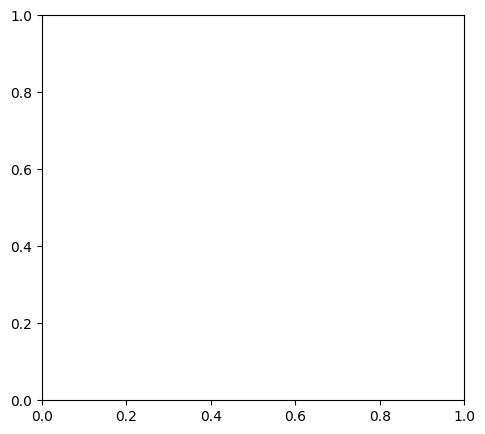

In [89]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_history, marker='o', color='orange', label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [90]:
len(loss_history)

5

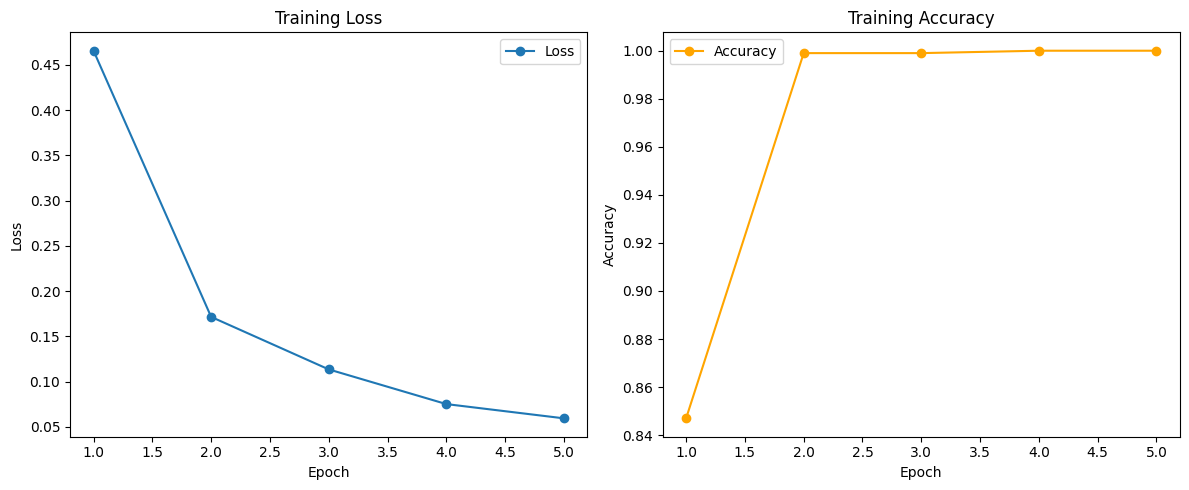

In [91]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss_history) + 1), accuracy_history, marker='o', color='orange', label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

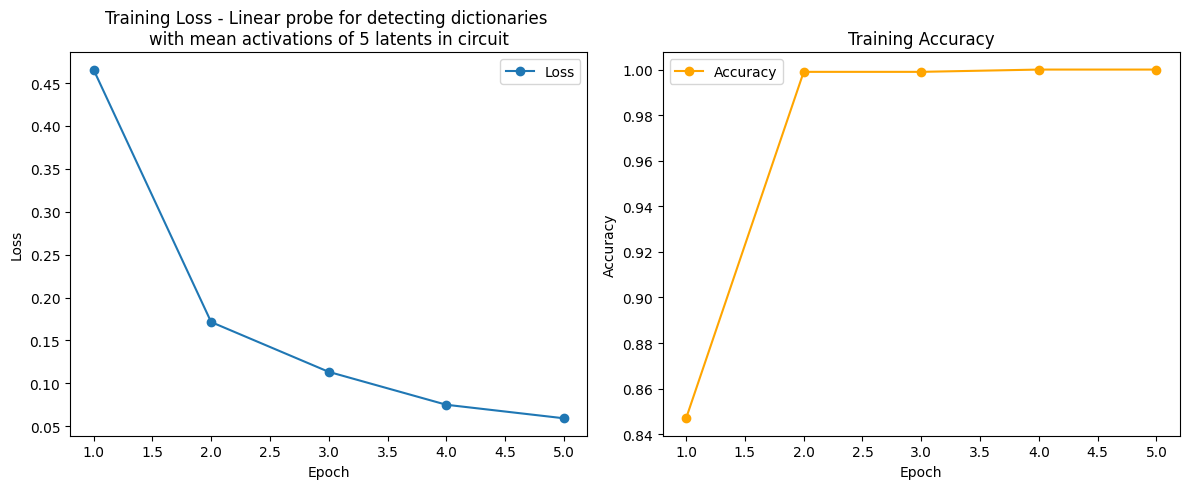

In [92]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss - Linear probe for detecting dictionaries \nwith mean activations of 5 latents in circuit")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss_history) + 1), accuracy_history, marker='o', color='orange', label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

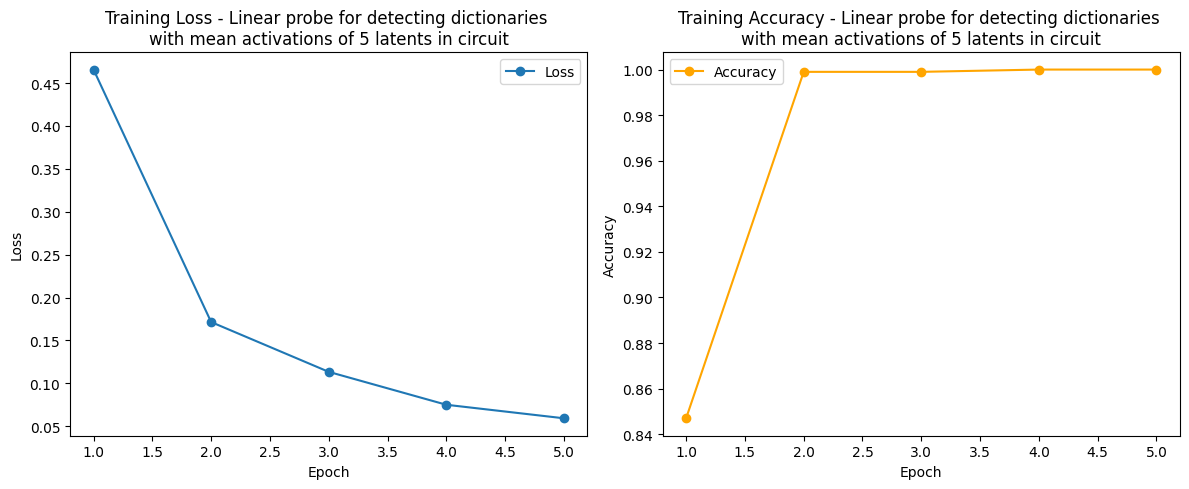

In [93]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss - Linear probe for detecting dictionaries \nwith mean activations of 5 latents in circuit")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss_history) + 1), accuracy_history, marker='o', color='orange', label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy - Linear probe for detecting dictionaries \nwith mean activations of 5 latents in circuit")
plt.legend()

plt.tight_layout()
plt.show()

In [94]:
# Updated version to return JSON with more names and structure for correct and incorrect keying examples

import json
import random

# Expanding the name pool with a larger set of names
extended_name_pool = [
    "Bob", "Sam", "Lilly", "Rob", "Alice", "Charlie", "Sally", "Tom", "Jake", "Emily", 
    "Megan", "Chris", "Sophia", "James", "Oliver", "Isabella", "Mia", "Jackson", 
    "Emma", "Ava", "Lucas", "Benjamin", "Ethan", "Grace", "Olivia", "Liam", "Noah"
]

for name in extended_name_pool:
    assert len(model.tokenizer.encode(name)) == 2, f"Name {name} has more than 1 token"

# Function to generate the dataset with correct and incorrect keying into dictionaries
def generate_extended_dataset(name_pool, num_samples=5):
    dataset = []
    
    for _ in range(num_samples):
        # Randomly select 5 names from the pool
        selected_names = random.sample(name_pool, 5)
        # Assign random ages to the selected names
        age_dict = {name: random.randint(10, 19) for name in selected_names}
        
        # Create a correct example
        correct_name = random.choice(list(age_dict.keys()))
        correct_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{correct_name}"]\n'
        correct_response = age_dict[correct_name]
        correct_token = str(correct_response)[0]
        
        # Create an incorrect example with a name not in the dictionary
        incorrect_name = random.choice([name for name in name_pool if name not in age_dict])
        incorrect_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{incorrect_name}"]\n'
        incorrect_response = "Traceback"
        incorrect_token = "Traceback"
        
        # Append the pair of correct and incorrect examples
        dataset.append({
            "correct": {
                "prompt": correct_prompt,
                "response": correct_response,
                "token": correct_token
            },
            "error": {
                "prompt": incorrect_prompt,
                "response": incorrect_response,
                "token": incorrect_token
            }
        })
        
    return dataset

# Generate the extended dataset
json_dataset = generate_extended_dataset(extended_name_pool, num_samples=100_000)

clean_prompts = []
corr_prompts = []

answer_token = model.to_single_token("1")
traceback_token = model.to_single_token("Traceback")

for item in json_dataset[:50]:
    corr_prompts.append(item["correct"]["prompt"])
    clean_prompts.append(item["error"]["prompt"])

clean_tokens = model.to_tokens(clean_prompts)
corr_tokens = model.to_tokens(corr_prompts)

In [95]:
def logit_diff_fn(logits):
    err = logits[:, -1, traceback_token]
    no_err = logits[:, -1, answer_token]
    return (err - no_err).mean()

# Disable gradients for all parameters
for param in model.parameters():
   param.requires_grad_(False)

# # Compute logits for clean and corrupted samples
logits = model(clean_tokens)
clean_diff = logit_diff_fn(logits)

logits = model(corr_tokens)
corr_diff = logit_diff_fn(logits)

print(f"clean_diff: {clean_diff}")
print(f"corr_diff: {corr_diff}")

# # Cleanup
del logits
cleanup_cuda()

# # Define error type metric
def _err_type_metric(logits, clean_logit_diff, corr_logit_diff):
    patched_logit_diff = logit_diff_fn(logits)
    return (patched_logit_diff - corr_logit_diff) / (clean_logit_diff - corr_logit_diff)

err_metric_denoising = partial(_err_type_metric, clean_logit_diff=clean_diff, corr_logit_diff=corr_diff)

RuntimeError: The size of tensor a (26) must match the size of tensor b (65) at non-singleton dimension 1

In [96]:
def run_with_saes_filtered_cache(tokens, filtered_ids, model, saes):
    with torch.no_grad():  # Global no_grad for performance
        
        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Equivalent to unsqueeze(-1)

        sae_outs = {}
        
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Apply torch.where only if mask_expanded has True values
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_outs


def run_with_saes_latent_op_patch(new_tokens, filtered_ids, model, saes, cache, dict_feats):
   # Ensure tokens are a torch.Tensor
   if not isinstance(new_tokens, torch.Tensor):
       new_tokens = torch.tensor(new_tokens).to(model.cfg.device)  # Move to the device of the model

   # Create a mask where True indicates positions to modify
   mask = torch.ones_like(new_tokens, dtype=torch.bool)
   for token_id in filtered_ids:
       mask &= new_tokens != token_id

   # Expand the mask once, so it matches the shape [batch_size, seq_len, 1]
   mask_expanded = mask.unsqueeze(-1)  # Expand to allow broadcasting
   mask_expanded = mask_expanded.to(model.cfg.device)  # Move the mask to the same device as the model
   # For each SAE, add the appropriate hook
   for sae in saes:
       hook_point = sae.cfg.hook_name

       # Define the filtered hook function (optimized)
       def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
           # Apply the SAE only where mask_expanded is True
           enc_sae = sae.encode(act)  # Call the SAE once
          
           if hook.name in cache and hook.name in dict_feats:
               prev_sae = cache[hook.name].to(device)   # Get cached activations from the cache
               feature_indices = dict_feats[hook.name]  # Get the feature indices to patch

               for feature_idx in range(sae.cfg.d_sae):
                   if feature_idx in feature_indices:
                       enc_sae[:, :, feature_idx] = prev_sae[:, :, feature_idx]

           # After patching, decode the modified enc_sae
           modified_act = sae.decode(enc_sae)

           # In-place update where the mask is True
           updated_act = torch.where(mask_expanded, modified_act, act)

           return updated_act

       # Add the hook to the model
       model.add_hook(hook_point, filtered_hook, dir='fwd')

   # Run the model with the tokens (no gradients needed)
   with torch.no_grad():
       logits = model(new_tokens)

   # Reset the hooks after computation to free memory
   model.reset_hooks()

   return logits  # Return only the logits

def run_with_saes_latent_op_patch_cache(new_tokens, filtered_ids, model, saes, cache, dict_feats):
    with torch.no_grad():  # Global no_grad for efficiency

        # Ensure new_tokens is a tensor on the correct device
        new_tokens = torch.as_tensor(new_tokens, device=model.cfg.device)
        
        # Create mask in a vectorized way
        mask = ~torch.isin(new_tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Expand dimensions directly
        
        # Cache hook names and feature indices outside the hook
        sae_hook_configs = [(sae.cfg.hook_name, sae, dict_feats.get(sae.cfg.hook_name, [])) for sae in saes]
        sae_outs = {}

        # Define and apply hooks
        for hook_name, sae, feature_indices in sae_hook_configs:
            def filtered_hook(act, hook, sae=sae, feature_indices=feature_indices, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                if hook.name in cache and feature_indices:
                    # Vectorized update of selected feature indices
                    enc_sae[:, :, feature_indices] = cache[hook.name][:, :, feature_indices].to(device) 

                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Only apply torch.where if needed
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_name, filtered_hook, dir='fwd')

        logits = model(new_tokens)
        model.reset_hooks()

    return logits, sae_outs
    
def run_with_saes_zero_ablation(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]

        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0

                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits


def run_with_saes_zero_ablation_cache(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out


def run_with_saes_zero_ablation_cache_tokens(tokens, filtered_ids, model, saes, dict_feats, token_pos):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    # Zero out only at specified token positions
                    for pos in token_pos:
                        enc_sae[:, pos, zero_indices] = 0
                    # enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out


def run_with_saes_zero_ablation_cache_tokens_separate(tokens, filtered_ids, model, saes, dict_feats, dict_feats_v2, token_pos):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    feature_indices_v2 = dict_feats_v2[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)

                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]

                    enc_sae[:, :, zero_indices] = 0

                    zero_indices_v2 = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices_v2, device=model.cfg.device))]
                    # Zero out only at specified token positions
                    if feature_indices_v2:
                        for pos in token_pos:
                            enc_sae[:, pos, zero_indices_v2] = 0
                    
                    # enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out

In [97]:
model.reset_hooks()
def logit_diff_fn(logits):
    err = logits[:, -1, traceback_token]
    no_err = logits[:, -1, answer_token]
    return (err - no_err).mean()

# Disable gradients for all parameters
for param in model.parameters():
   param.requires_grad_(False)

# # Compute logits for clean and corrupted samples
logits = model(clean_tokens)
clean_diff = logit_diff_fn(logits)

logits = model(corr_tokens)
corr_diff = logit_diff_fn(logits)

print(f"clean_diff: {clean_diff}")
print(f"corr_diff: {corr_diff}")

# # Cleanup
del logits
cleanup_cuda()

# # Define error type metric
def _err_type_metric(logits, clean_logit_diff, corr_logit_diff):
    patched_logit_diff = logit_diff_fn(logits)
    return (patched_logit_diff - corr_logit_diff) / (clean_logit_diff - corr_logit_diff)

err_metric_denoising = partial(_err_type_metric, clean_logit_diff=clean_diff, corr_logit_diff=corr_diff)

clean_diff: 7.244808197021484
corr_diff: -7.036718368530273


In [98]:
def run_with_saes_filtered_cache(tokens, filtered_ids, model, saes):
    with torch.no_grad():  # Global no_grad for performance
        
        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Equivalent to unsqueeze(-1)

        sae_outs = {}
        
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Apply torch.where only if mask_expanded has True values
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_outs


def run_with_saes_latent_op_patch(new_tokens, filtered_ids, model, saes, cache, dict_feats):
   # Ensure tokens are a torch.Tensor
   if not isinstance(new_tokens, torch.Tensor):
       new_tokens = torch.tensor(new_tokens).to(model.cfg.device)  # Move to the device of the model

   # Create a mask where True indicates positions to modify
   mask = torch.ones_like(new_tokens, dtype=torch.bool)
   for token_id in filtered_ids:
       mask &= new_tokens != token_id

   # Expand the mask once, so it matches the shape [batch_size, seq_len, 1]
   mask_expanded = mask.unsqueeze(-1)  # Expand to allow broadcasting
   mask_expanded = mask_expanded.to(model.cfg.device)  # Move the mask to the same device as the model
   # For each SAE, add the appropriate hook
   for sae in saes:
       hook_point = sae.cfg.hook_name

       # Define the filtered hook function (optimized)
       def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
           # Apply the SAE only where mask_expanded is True
           enc_sae = sae.encode(act)  # Call the SAE once
          
           if hook.name in cache and hook.name in dict_feats:
               prev_sae = cache[hook.name].to(device)   # Get cached activations from the cache
               feature_indices = dict_feats[hook.name]  # Get the feature indices to patch

               for feature_idx in range(sae.cfg.d_sae):
                   if feature_idx in feature_indices:
                       enc_sae[:, :, feature_idx] = prev_sae[:, :, feature_idx]

           # After patching, decode the modified enc_sae
           modified_act = sae.decode(enc_sae)

           # In-place update where the mask is True
           updated_act = torch.where(mask_expanded, modified_act, act)

           return updated_act

       # Add the hook to the model
       model.add_hook(hook_point, filtered_hook, dir='fwd')

   # Run the model with the tokens (no gradients needed)
   with torch.no_grad():
       logits = model(new_tokens)

   # Reset the hooks after computation to free memory
   model.reset_hooks()

   return logits  # Return only the logits

def run_with_saes_latent_op_patch_cache(new_tokens, filtered_ids, model, saes, cache, dict_feats):
    with torch.no_grad():  # Global no_grad for efficiency

        # Ensure new_tokens is a tensor on the correct device
        new_tokens = torch.as_tensor(new_tokens, device=model.cfg.device)
        
        # Create mask in a vectorized way
        mask = ~torch.isin(new_tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Expand dimensions directly
        
        # Cache hook names and feature indices outside the hook
        sae_hook_configs = [(sae.cfg.hook_name, sae, dict_feats.get(sae.cfg.hook_name, [])) for sae in saes]
        sae_outs = {}

        # Define and apply hooks
        for hook_name, sae, feature_indices in sae_hook_configs:
            def filtered_hook(act, hook, sae=sae, feature_indices=feature_indices, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                if hook.name in cache and feature_indices:
                    # Vectorized update of selected feature indices
                    enc_sae[:, :, feature_indices] = cache[hook.name][:, :, feature_indices].to(device) 

                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Only apply torch.where if needed
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_name, filtered_hook, dir='fwd')

        logits = model(new_tokens)
        model.reset_hooks()

    return logits, sae_outs
    
def run_with_saes_zero_ablation(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]

        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0

                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits


def run_with_saes_zero_ablation_cache(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out


def run_with_saes_zero_ablation_cache_tokens(tokens, filtered_ids, model, saes, dict_feats, token_pos):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    # Zero out only at specified token positions
                    for pos in token_pos:
                        enc_sae[:, pos, zero_indices] = 0
                    # enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out


def run_with_saes_zero_ablation_cache_tokens_separate(tokens, filtered_ids, model, saes, dict_feats, dict_feats_v2, token_pos):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    feature_indices_v2 = dict_feats_v2[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)

                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]

                    enc_sae[:, :, zero_indices] = 0

                    zero_indices_v2 = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices_v2, device=model.cfg.device))]
                    # Zero out only at specified token positions
                    if feature_indices_v2:
                        for pos in token_pos:
                            enc_sae[:, pos, zero_indices_v2] = 0
                    
                    # enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out

In [99]:
cleanup_cuda()

In [100]:
model.reset_hooks()
filtered_ids = [model.tokenizer.bos_token_id]
clean_sae_logits, clean_sae_cache = run_with_saes_filtered_cache(clean_tokens, filtered_ids, model, saes)
corr_sae_logits, corr_sae_cache = run_with_saes_filtered_cache(corr_tokens, filtered_ids, model, saes)

clean_sae_diff = logit_diff_fn(clean_sae_logits)
corr_sae_diff = logit_diff_fn(corr_sae_logits)

print(f"clean_sae_diff: {clean_sae_diff}")
print(f"corr_sae_diff: {corr_sae_diff}")

clean_sae_diff: 2.1515071392059326
corr_sae_diff: -6.843043804168701


In [101]:
with open('mask_finding/mask.json') as f:
    mask = json.load(f)

# load clustered latnets as cluster_results 
with open('mask_finding/out/clustering/clustered_latents.json') as f:
    cluster_results = json.load(f)

# load the drop results json
with open('mask_finding/out/clustering/drop_results.json') as f:
    drop_results = json.load(f)

In [102]:
index_helper_latents = {'blocks.7.hook_resid_post': [4287, 11707, 12134]}

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(index_helper_latents["blocks.7.hook_resid_post"]))

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, filtered_mask)

log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
circuit_dup_ablated_answer = log_probs_answer.mean().detach().cpu().item()
circuit_dup_ablated_traceback = log_probs_traceback.mean().detach().cpu().item()
print("Duplicate cluster ablated: ", circuit_dup_ablated_answer)
print("Duplicate cluster ablated, all latents: ", circuit_dup_ablated_traceback)

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
full_circuit_perf = log_probs_answer.mean().detach().cpu().item()
full_circuit_traceback = log_probs_traceback.mean().detach().cpu().item()
print("Full circuit perf: ", full_circuit_perf)
print("Full circuit perf: ", full_circuit_traceback)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated:  0.29963889718055725
Duplicate cluster ablated, all latents:  0.03230840712785721
Full circuit perf:  0.7000826597213745
Full circuit perf:  0.15954190492630005


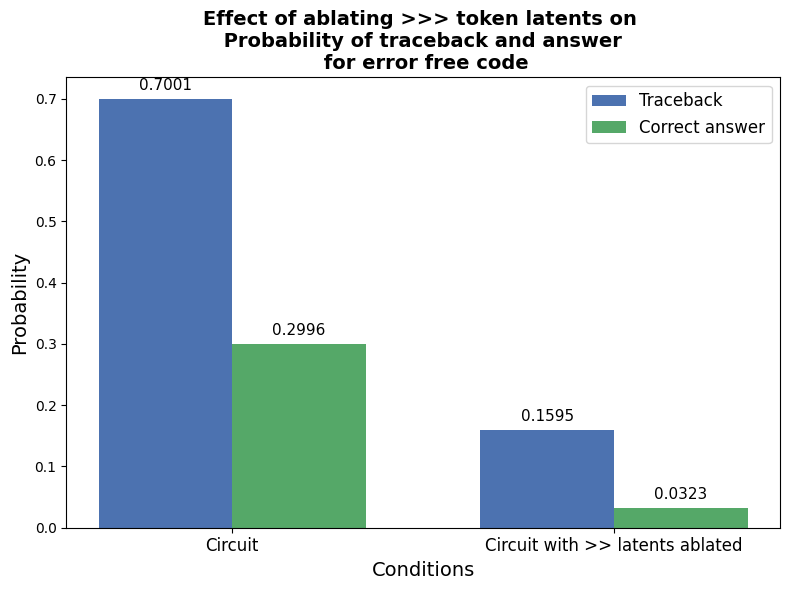

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Circuit', 'Circuit with >> latents ablated']
ablated_values = [full_circuit_perf, full_circuit_traceback]
non_ablated_values = [circuit_dup_ablated_answer, circuit_dup_ablated_traceback]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width / 2, ablated_values, width=bar_width, label='Traceback ', color='#4C72B0')
bars2 = plt.bar(x + bar_width / 2, non_ablated_values, width=bar_width, label='Correct answer', color='#55A868')

# Title and labels
plt.title("Effect of ablating >>> token latents on \n Probability of traceback and answer \n for error free code", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Probability", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

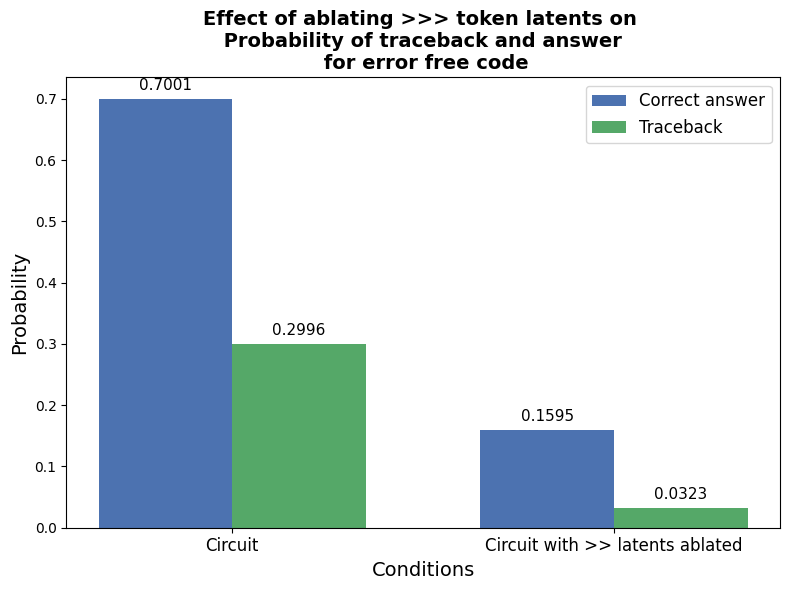

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Circuit', 'Circuit with >> latents ablated']
ablated_values = [full_circuit_perf, full_circuit_traceback]
non_ablated_values = [circuit_dup_ablated_answer, circuit_dup_ablated_traceback]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width / 2, ablated_values, width=bar_width, label='Correct answer', color='#4C72B0')
bars2 = plt.bar(x + bar_width / 2, non_ablated_values, width=bar_width, label='Traceback', color='#55A868')

# Title and labels
plt.title("Effect of ablating >>> token latents on \n Probability of traceback and answer \n for error free code", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Probability", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

In [105]:
index_helper_latents = {'blocks.7.hook_resid_post': [4287, 11707, 12134]}

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(index_helper_latents["blocks.7.hook_resid_post"]))

model.reset_hooks()
logits = run_with_saes_zero_ablation(clean_tokens, filtered_ids, model, saes, filtered_mask)

log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
circuit_dup_ablated_answer = log_probs_answer.mean().detach().cpu().item()
circuit_dup_ablated_traceback = log_probs_traceback.mean().detach().cpu().item()
print("Duplicate cluster ablated: ", circuit_dup_ablated_answer)
print("Duplicate cluster ablated, all latents: ", circuit_dup_ablated_traceback)

model.reset_hooks()
logits = run_with_saes_zero_ablation(clean_tokens, filtered_ids, model, saes, mask)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
full_circuit_perf = log_probs_answer.mean().detach().cpu().item()
full_circuit_traceback = log_probs_traceback.mean().detach().cpu().item()
print("Full circuit perf: ", full_circuit_perf)
print("Full circuit perf: ", full_circuit_traceback)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated:  0.13545137643814087
Duplicate cluster ablated, all latents:  0.007095388136804104
Full circuit perf:  0.28402552008628845
Full circuit perf:  0.4986507296562195


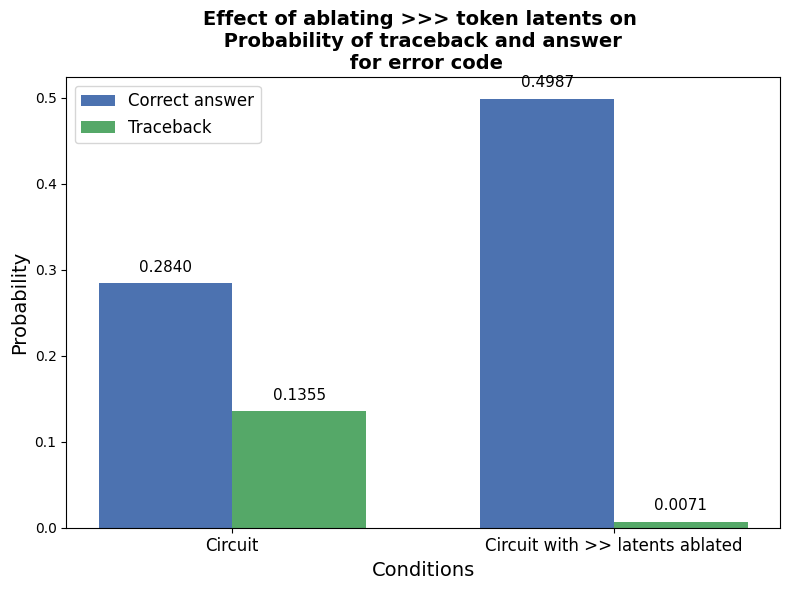

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Circuit', 'Circuit with >> latents ablated']
ablated_values = [full_circuit_perf, full_circuit_traceback]
non_ablated_values = [circuit_dup_ablated_answer, circuit_dup_ablated_traceback]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width / 2, ablated_values, width=bar_width, label='Correct answer', color='#4C72B0')
bars2 = plt.bar(x + bar_width / 2, non_ablated_values, width=bar_width, label='Traceback', color='#55A868')

# Title and labels
plt.title("Effect of ablating >>> token latents on \n Probability of traceback and answer \n for error code", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Probability", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

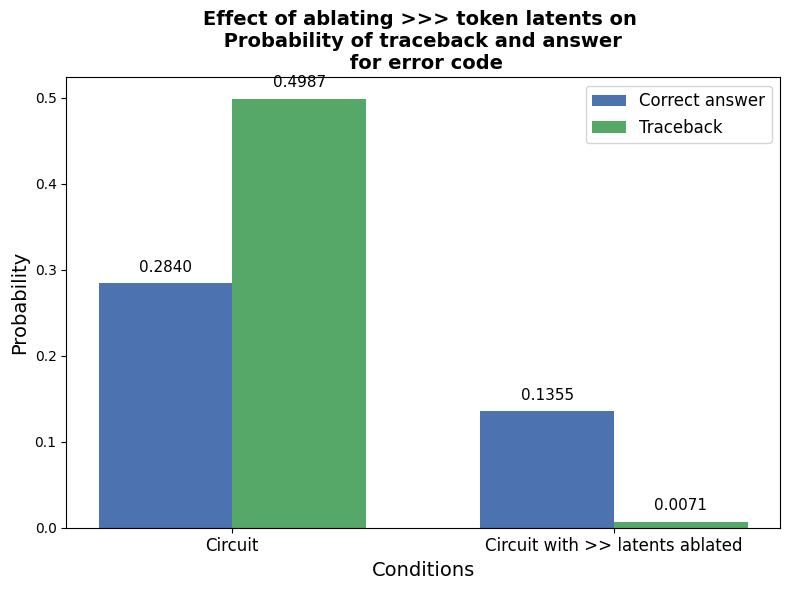

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Circuit', 'Circuit with >> latents ablated']
ablated_values = [full_circuit_perf, circuit_dup_ablated_answer]
non_ablated_values = [full_circuit_traceback,circuit_dup_ablated_traceback]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width / 2, ablated_values, width=bar_width, label='Correct answer', color='#4C72B0')
bars2 = plt.bar(x + bar_width / 2, non_ablated_values, width=bar_width, label='Traceback', color='#55A868')

# Title and labels
plt.title("Effect of ablating >>> token latents on \n Probability of traceback and answer \n for error code", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Probability", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

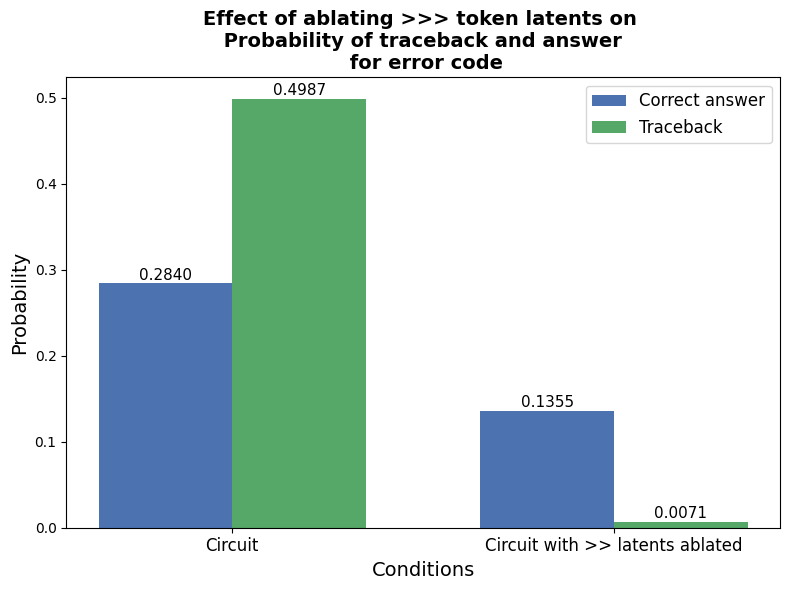

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Circuit', 'Circuit with >> latents ablated']
ablated_values = [full_circuit_perf, circuit_dup_ablated_answer]
non_ablated_values = [full_circuit_traceback,circuit_dup_ablated_traceback]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width / 2, ablated_values, width=bar_width, label='Correct answer', color='#4C72B0')
bars2 = plt.bar(x + bar_width / 2, non_ablated_values, width=bar_width, label='Traceback', color='#55A868')

# Title and labels
plt.title("Effect of ablating >>> token latents on \n Probability of traceback and answer \n for error code", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Probability", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.001, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

In [109]:
index_helper_latents = {'blocks.7.hook_resid_post': [4287, 11707, 12134]}

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(index_helper_latents["blocks.7.hook_resid_post"]))

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, filtered_mask)

log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
circuit_dup_ablated_answer = log_probs_answer.mean().detach().cpu().item()
circuit_dup_ablated_traceback = log_probs_traceback.mean().detach().cpu().item()
print("Duplicate cluster ablated: ", circuit_dup_ablated_answer)
print("Duplicate cluster ablated, all latents: ", circuit_dup_ablated_traceback)

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs_answer = log_probs[:, -1, answer_token]
log_probs_traceback = log_probs[:, -1, traceback_token]
full_circuit_perf = log_probs_answer.mean().detach().cpu().item()
full_circuit_traceback = log_probs_traceback.mean().detach().cpu().item()
print("Full circuit perf: ", full_circuit_perf)
print("Full circuit perf: ", full_circuit_traceback)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated:  0.29963889718055725
Duplicate cluster ablated, all latents:  0.03230840712785721
Full circuit perf:  0.7000826597213745
Full circuit perf:  0.15954190492630005


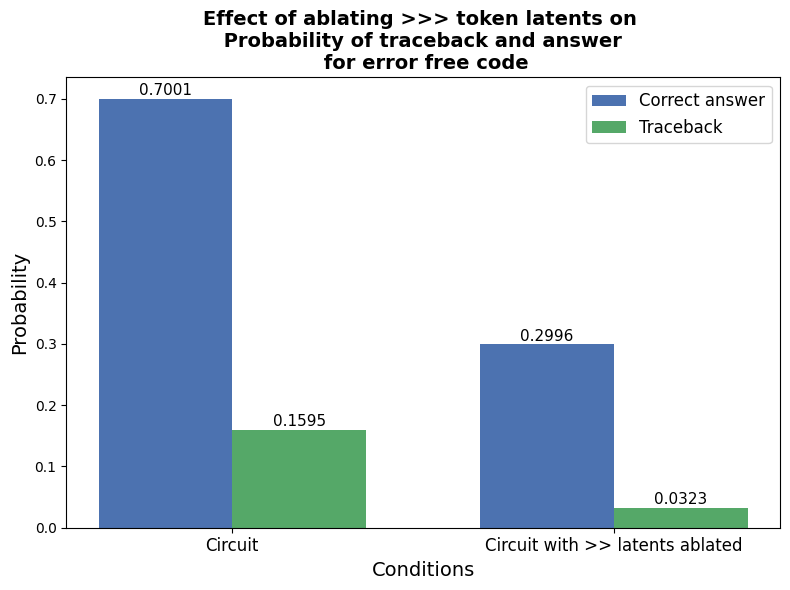

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Circuit', 'Circuit with >> latents ablated']
ablated_values = [full_circuit_perf, circuit_dup_ablated_answer]
non_ablated_values = [full_circuit_traceback,circuit_dup_ablated_traceback]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width / 2, ablated_values, width=bar_width, label='Correct answer', color='#4C72B0')
bars2 = plt.bar(x + bar_width / 2, non_ablated_values, width=bar_width, label='Traceback', color='#55A868')

# Title and labels
plt.title("Effect of ablating >>> token latents on \n Probability of traceback and answer \n for error free code", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Probability", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.001, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()